In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBoost
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["figure.dpi"] = 150
plt.style.use("seaborn");plt.style.use("classic")
from itertools import product
%config InlineBackend.figure_format='retina'

In [ ]:
cd data

In [8]:
#load data
with open("data_w", "rb") as f:
    data_w = pickle.load(f)
    
with open("data_2w", "rb") as f:
    data_2w = pickle.load(f)
    
with open("data_3w", "rb") as f:
    data_3w = pickle.load(f)
    
with open("data_m", "rb") as f:
    data_m = pickle.load(f)
    
cities = list(data_m.keys())

# vector of interest
target_vector = ['create', 'modify','tag_add',
            'tag_del', 'tag_change','loc_change',
            'new_mapper']

# We test a small set of parameters for the Models.
# We dont use excessive parameter adjustment because we do not use Cross Val, therefore hardcoding the best set of parameters is pointless.
model_params = {"VAR" : {"alpha" : [1, 5, 15, 20], "tolerance" : [.15], "max_lag" : list(range(1, 5)) },
                "RF" :   {"max_depth" : [1, 10, 15, 20, None], "max_lag" : list(range(1, 5)) }
                }

In [9]:
def baseline1(data, city, cols, test_size):
    dat = data[city][cols].copy()
    y = dat[-test_size:]
    #y_train = dat[:-test_size]
    pred = dat[-test_size-1:].shift(1).dropna()
    SE = (y - pred )**2
    #AE = np.abs(pred - y)
    #SE_naive = (y_train.mean() - y)**2
    #AE_naive = np.abs((y_train.mean() - y))
    #RRSE = np.sqrt((SE.sum()/SE_naive.sum()))
    #RAE = AE.sum()/AE_naive.sum()
    RMSE = np.sqrt(SE.mean())
    #NRMSE = RMSE/dat.std()
    res = RMSE.to_dict()
    res["MRMSE"] = RMSE.mean()
    res["city"] = city
    return res

def baseline2(data, city,cols, test_size):
    dat = data[city][cols].copy()
    y = dat[-test_size:]
    #y_train = dat[:-test_size]
    pred = dat[-test_size-2:].shift(1).rolling(2).mean().dropna()
    SE = (y - pred )**2
    #AE = np.abs(pred - y)
    #SE_naive = (y_train.mean() - y)**2
    #AE_naive = np.abs((y_train.mean() - y))
    #RRSE = np.sqrt((SE.sum()/SE_naive.sum()))
    #RAE = AE.sum()/AE_naive.sum()
    RMSE = np.sqrt(SE.mean())
    #NRMSE = RMSE/dat.std()
    res = RMSE.to_dict()
    res["MRMSE"] = RMSE.mean()
    res["city"] = city
    return res

In [12]:
def build_model(method, dat, max_lag, n_test,
            max_depth, lr, alpha, tolerance, temporal_features=True):
    cols = target_vector
    lag=max_lag
    n_trees = 200
    #start with a fresh df
    df = dat[cols].copy()
    if temporal_features and method != "VAR":
        if df.index.freq == "m":
            df["month"] = df.index.month
        else:
            df["week"] = df.index.week
            df["month"] = df.index.month
    # create objective matrix
    for col in cols:
        for l in range(1, lag+1):
            df[col+"(t-%s)" % l] = df[col].shift(l)
    df = df.dropna()
    X = df[df.columns.difference(cols)].values
    y = df[cols].values
    y_train, y_test = y[:-n_test], y[-n_test:]#make sanity check
    X_train, X_test = X[:-n_test], X[-n_test:]#make sanity check
    
    #Train 
    if method =="RF":
        RF = RandomForestRegressor(n_estimators=n_trees,
                                   max_depth = max_depth, n_jobs=-1)
        RF.fit(X_train, y_train)
        pred = RF.predict(X_test)
    elif method =="GB":
        GB = MultiOutputRegressor(GBoost(learning_rate=lr,
                                         n_estimators=n_trees,
                                         max_depth=max_depth), n_jobs=-1)
        GB.fit(X_train, y_train)
        pred = GB.predict(X_test)
    elif method =="VAR":
        VAR = Lasso(alpha=alpha, tol=tolerance)
        VAR.fit(X_train, y_train)
        pred = VAR.predict(X_test)
    else:
        raise ValueError("Method unknown.")

    true = y_test
    SE = (pd.DataFrame(true, columns=cols) - pd.DataFrame(pred, columns=cols))**2
    
    #RMSE per variable
    #np.sqrt(SE.mean())
    # Mean RMSE for all of the vars
    #np.sqrt(SE.mean()).mean()
    return SE

 
                                                                                             
def best_fit(method, data, params, test_size, start_training="2008"):
    global target_vector
    results = list()
    param_combinations = product(*list(params.values()))
    for combination in param_combinations:
        for city in data:
            combi = { list(params.keys())[i] : combination[i] for i in range(len(combination)) }
            combi["city"] = city

            dat_ = data[city][start_training:]
            SE = build_model(method=method, dat=dat_, max_lag=combi.get("max_lag"),
                             n_test=test_size,
                             max_depth=combi.get("max_depth"), lr=combi.get("lr"),
                             alpha=combi.get("alpha"), tolerance=combi.get("tolerance"))
            RMSE = np.sqrt(SE.mean())
            for x in target_vector:
                combi["RMSE(% s)" % x] = RMSE.get(x)
            combi["MRMSE"] = RMSE.mean()
            results.append(combi)    
            
    return pd.DataFrame(results)



def compare_models(data, model_params, test_size):
    model_results = {}
    #Model Param Search
    print("Fitting the linear Model...")
    df_var = best_fit("VAR", data, model_params["VAR"], test_size)
    print("Fitting the Random Forest...")
    df_rf = best_fit("RF", data, model_params["RF"], test_size)
    #Baseline Models
    res_bl1 = pd.DataFrame([baseline1(data, city,
                                             target_vector,
                                             test_size) for city in data])
    res_bl2 = pd.DataFrame([baseline2(data, city,
                                             target_vector,
                                             test_size) for city in data])
    for city in data:
        d_var = df_var[df_var["city"] == city].loc[df_var[df_var["city"] == city].MRMSE.idxmin()].to_dict()
        d_rf = df_rf[df_rf["city"] == city].loc[df_rf[df_rf["city"] == city].MRMSE.idxmin()].to_dict()
        del d_rf["city"], d_var["city"]
        
        d_rf["Model"] = "RF"
        d_var["Model"] = "LVAR"
       
        
        dat_ = [d_var, d_rf]
        
        BL1 = res_bl1[res_bl1["city"] == city].to_dict()
        BL2 = res_bl2[res_bl2["city"] == city].to_dict()
        
        dd = {"RMSE(%s)" % i : list(BL1[i].values())[0] for i in BL1 if i not in ["MRMSE", "city"]}
        dd["Model"] = "BL1"
        dd["MRMSE"] = list(BL1["MRMSE"].values())[0]
        dat_.append(dd)
        dd = {"RMSE(%s)" % i : list(BL2[i].values())[0] for i in BL2 if i not in ["MRMSE", "city"]}
        dd["MRMSE"] = list(BL2["MRMSE"].values())[0]
        dd["Model"] = "BL2"
        dat_.append(dd)
        
        model_results[city] = pd.DataFrame(dat_)
        model_results[city].index = model_results[city].Model
    
    return model_results

Run the actual experiment (May take a while)

In [ ]:
model_results_m = compare_models(data_m, model_params, 12)
model_results_3w = compare_models(data_3w, model_params, 16)
model_results_2w = compare_models(data_2w, model_params, 24)
model_results_w = compare_models(data_w, model_params, 48)

The explaination of this is trivial : Larger City -> Larger Unit range -> Larger Error

### Normalizing the RMSE

## Possibilities

$\operatorname{RAE}=\frac{\sum_{i=1}^{N}\left|\hat{\theta}_{i}-\theta_{i}\right|}{\sum_{i=1}^{N}\left|\bar{\theta}-\theta_{i}\right|}$

- Checked

$\operatorname{RRSE}=\sqrt{\frac{\sum_{i=1}^{N}\left(\hat{\theta}_{i}-\theta_{i}\right)^{2}}{\sum_{i=1}^{N}\left(\bar{\theta}-\theta_{i}\right)^{2}}}$

- Checked

$\mathbf{M}=\frac{100 \%}{n} \sum_{t=1}^{n}\left|\frac{A_{t}-F_{t}}{A_{t}}\right|$

- Checked

$\mathrm{NRMSD}=\frac{\mathrm{RMSD}}{y_{\max }-y_{\min }}$ or $\mathrm{NRMSD}=\frac{\mathrm{RMSD}}{\bar{y}}$

- Checked 

$\mathrm{RMSDIQR}=\frac{\mathrm{RMSD}}{I Q R} \text { where } I Q R=Q_{3}-Q_{1}$

with $Q_{1}=\mathrm{CDF}^{-1}(0.25)$ and $Q_{3}=\mathrm{CDF}^{-1}(0.75),$ where $\mathrm{CDF}^{-1}$ is the quantile function.

- Best way to normalize the RMSE

*Note* that Normalization is only necessary when comparing cities, to compare the models the normalization is not important since all models are training equally accross the cities.

In [16]:
def horizon_performance(city):
    return pd.DataFrame({"VAR" : [frequency[city].MRMSE.LVAR for frequency in [model_results_w, model_results_2w, model_results_3w, model_results_m]],
              "RF" : [frequency[city].MRMSE.RF for frequency in [model_results_w, model_results_2w, model_results_3w, model_results_m]],
              "BL1" : [frequency[city].MRMSE.BL1 for frequency in [model_results_w, model_results_2w, model_results_3w, model_results_m]],
              "BL2" : [frequency[city].MRMSE.BL2 for frequency in [model_results_w, model_results_2w, model_results_3w, model_results_m]]},
             index = ["1w", "2w", "3w", "4w"])

def city_performance(frequency, obj, normalize=True):
    obj_error = "RMSE(% s)" % obj
    if frequency == "w":
        model_results = model_results_w
        data = data_w
    elif frequency == "2w":
        model_results = model_results_2w
        data = data_2w
    elif frequency == "3w":
        model_results = model_results_3w
        data = data_3w
    elif frequency == "4w":
        model_results = model_results_m
        data = data_m
    if normalize:
        return pd.DataFrame({"LVAR" : [(model_results[city][obj_error]/(data[city][obj].quantile(0.75) - data[city][obj].quantile(0.25))).LVAR for city in cities],
                                     "RF" : [(model_results[city][obj_error]/(data[city][obj].quantile(0.75) - data[city][obj].quantile(0.25))).RF for city in cities],
                                     "BL1"  : [(model_results[city][obj_error]/(data[city][obj].quantile(0.75) - data[city][obj].quantile(0.25))).BL1 for city in cities],
                                     "BL2"  : [(model_results[city][obj_error]/(data[city][obj].quantile(0.75) - data[city][obj].quantile(0.25))).BL2 for city in cities]},index=cities)
    else:
        return pd.DataFrame({"LVAR" : [model_results[city][obj_error].LVAR for city in cities],
                             "RF" : [model_results[city][obj_error].RF for city in cities],
                             "BL1"  : [model_results[city][obj_error].BL1 for city in cities],
                             "BL2"  : [model_results[city][obj_error].BL2 for city in cities]},index=cities)

def compare_objective(model_results, obj):
    return pd.DataFrame({"LVAR" : [model_results[city][obj].LVAR for city in cities],
                                 "RF" : [model_results[city][obj].RF for city in cities],
                                 "BL1"  : [model_results[city][obj].BL1 for city in cities],
                                 "BL2"  : [model_results[city][obj].BL2 for city in cities]},
                                index=cities)

Text(0.5, 1.0, 'Mean Error over all cities and all horizons')

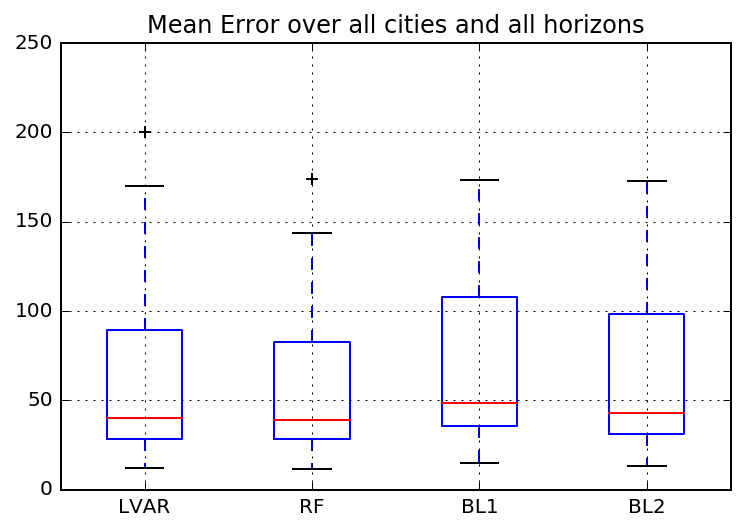

In [17]:
((compare_objective(model_results_w, "MRMSE") + compare_objective(model_results_2w, "MRMSE") + compare_objective(model_results_3w, "MRMSE") + compare_objective(model_results_m, "MRMSE"))/4).boxplot()
plt.title("Mean Error over all cities and all horizons")

Text(0.5, 0.98, 'Mean Vector RMSE, Time Horizon : 1w')

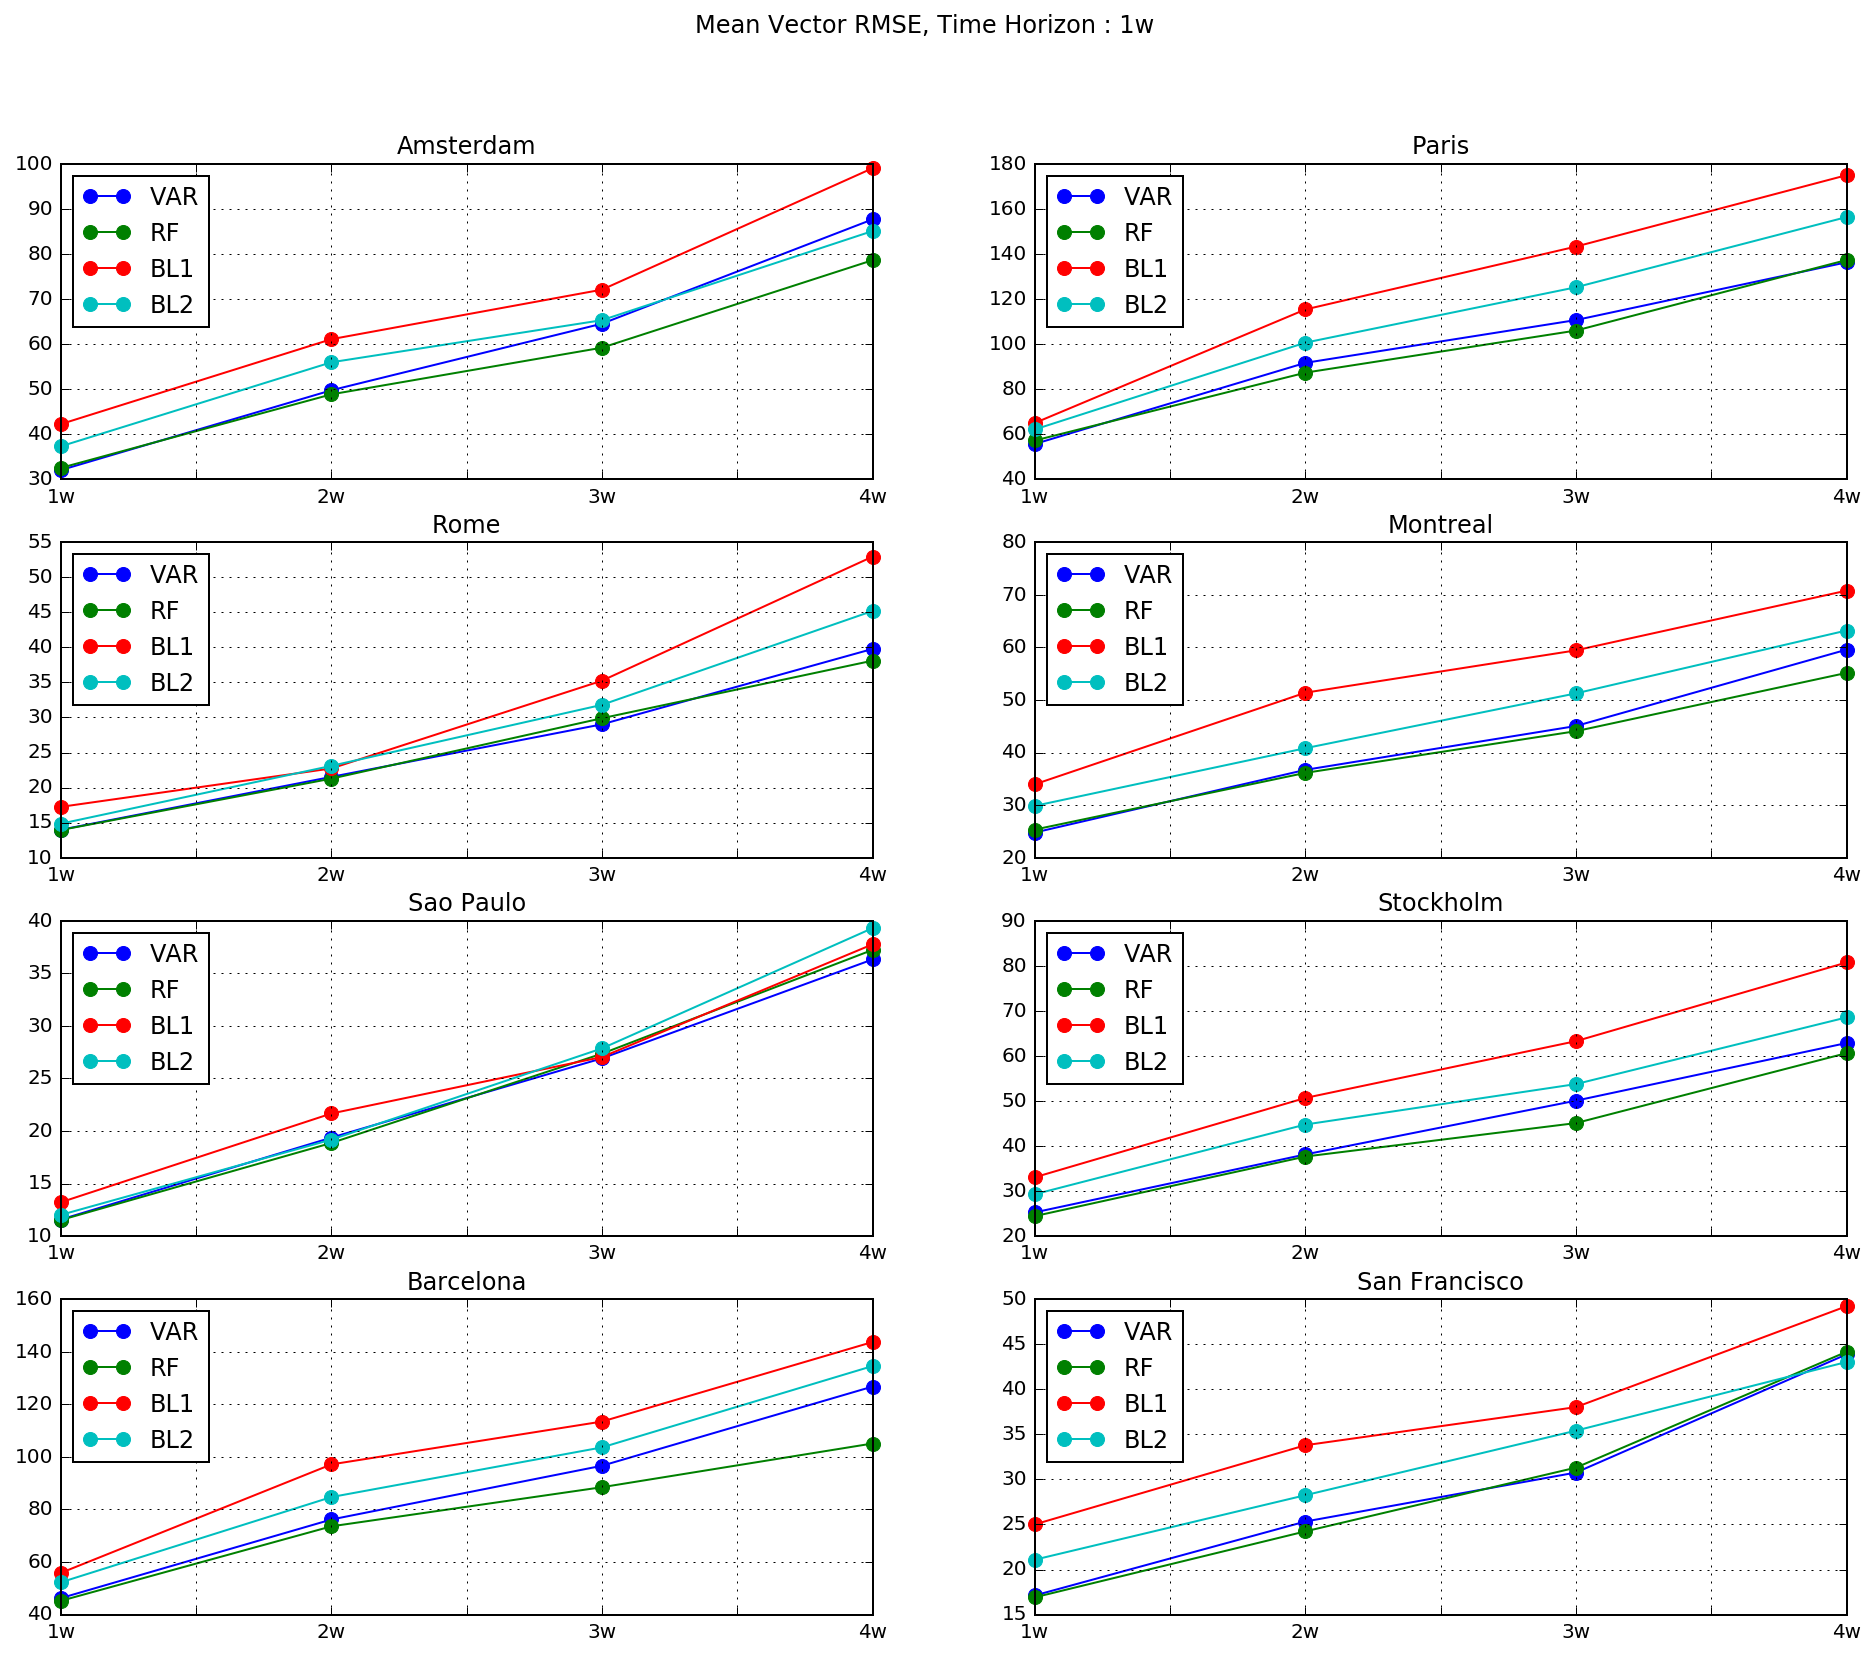

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16,13))
horizon_performance("Amsterdam").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[0,0])
axes[0,0].set_title("Amsterdam")
horizon_performance("Paris").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[0,1])
axes[0,1].set_title("Paris")
horizon_performance("Rome").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[1,0])
axes[1,0].set_title("Rome")
horizon_performance("Montreal").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[1,1])
axes[1,1].set_title("Montreal")
horizon_performance("Sao Paulo").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[2,0])
axes[2,0].set_title("Sao Paulo")
horizon_performance("Stockholm").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[2,1])
axes[2,1].set_title("Stockholm")
horizon_performance("Barcelona").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[3,0])
axes[3,0].set_title("Barcelona")
horizon_performance("San Francisco").plot(style=".-", grid=True,clip_on=False, ms=14, ax=axes[3,1])
axes[3,1].set_title("San Francisco")
fig.suptitle('Mean Vector RMSE, Time Horizon : 1w', fontsize=12)

In [19]:
# Aggregated
# Mean values over the cities 
agg = sum(horizon_performance(city) for city in cities)/len(cities)

In [21]:
model_results_2w["Stockholm"]

,alpha,tolerance,max_lag,RMSE(create),RMSE(modify),RMSE(tag_add),RMSE(tag_del),RMSE(tag_change),RMSE(loc_change),RMSE(new_mapper),MRMSE,Model,max_depth
Model,,,,,,,,,,,,,
LVAR,5.0,0.15,1.0,8.092264,97.731518,48.033428,16.834938,83.887002,9.675879,2.678792,38.133403,LVAR,NaN
RF,NaN,NaN,1.0,6.939775,98.946671,44.894507,16.284281,84.374043,9.620919,2.600017,37.665745,RF,20.0
BL1,NaN,NaN,NaN,7.390873,133.168909,52.369282,29.094673,118.313320,11.383468,2.986079,50.672372,BL1,NaN
BL2,NaN,NaN,NaN,7.653294,117.716246,47.317412,23.798634,102.867684,11.757090,2.295830,44.772313,BL2,NaN


In [20]:
model_results_m["Stockholm"]

,alpha,tolerance,max_lag,RMSE(create),RMSE(modify),RMSE(tag_add),RMSE(tag_del),RMSE(tag_change),RMSE(loc_change),RMSE(new_mapper),MRMSE,Model,max_depth
Model,,,,,,,,,,,,,
LVAR,20.0,0.15,4.0,17.112741,155.133781,93.204901,27.521449,119.040814,23.486343,4.468468,62.852643,LVAR,NaN
RF,NaN,NaN,3.0,16.597176,144.091482,89.368133,33.667546,116.849152,20.088454,3.612973,60.610702,RF,15.0
BL1,NaN,NaN,NaN,16.645820,195.615269,111.645645,48.769868,168.235945,20.562912,3.662877,80.734048,BL1,NaN
BL2,NaN,NaN,NaN,13.946326,167.618118,92.645044,41.874565,145.839238,14.962453,2.919047,68.543541,BL2,NaN


Text(0.5, 1.0, 'Mean Vector RMSE averaged over the 20 cities vs Time Horizon')

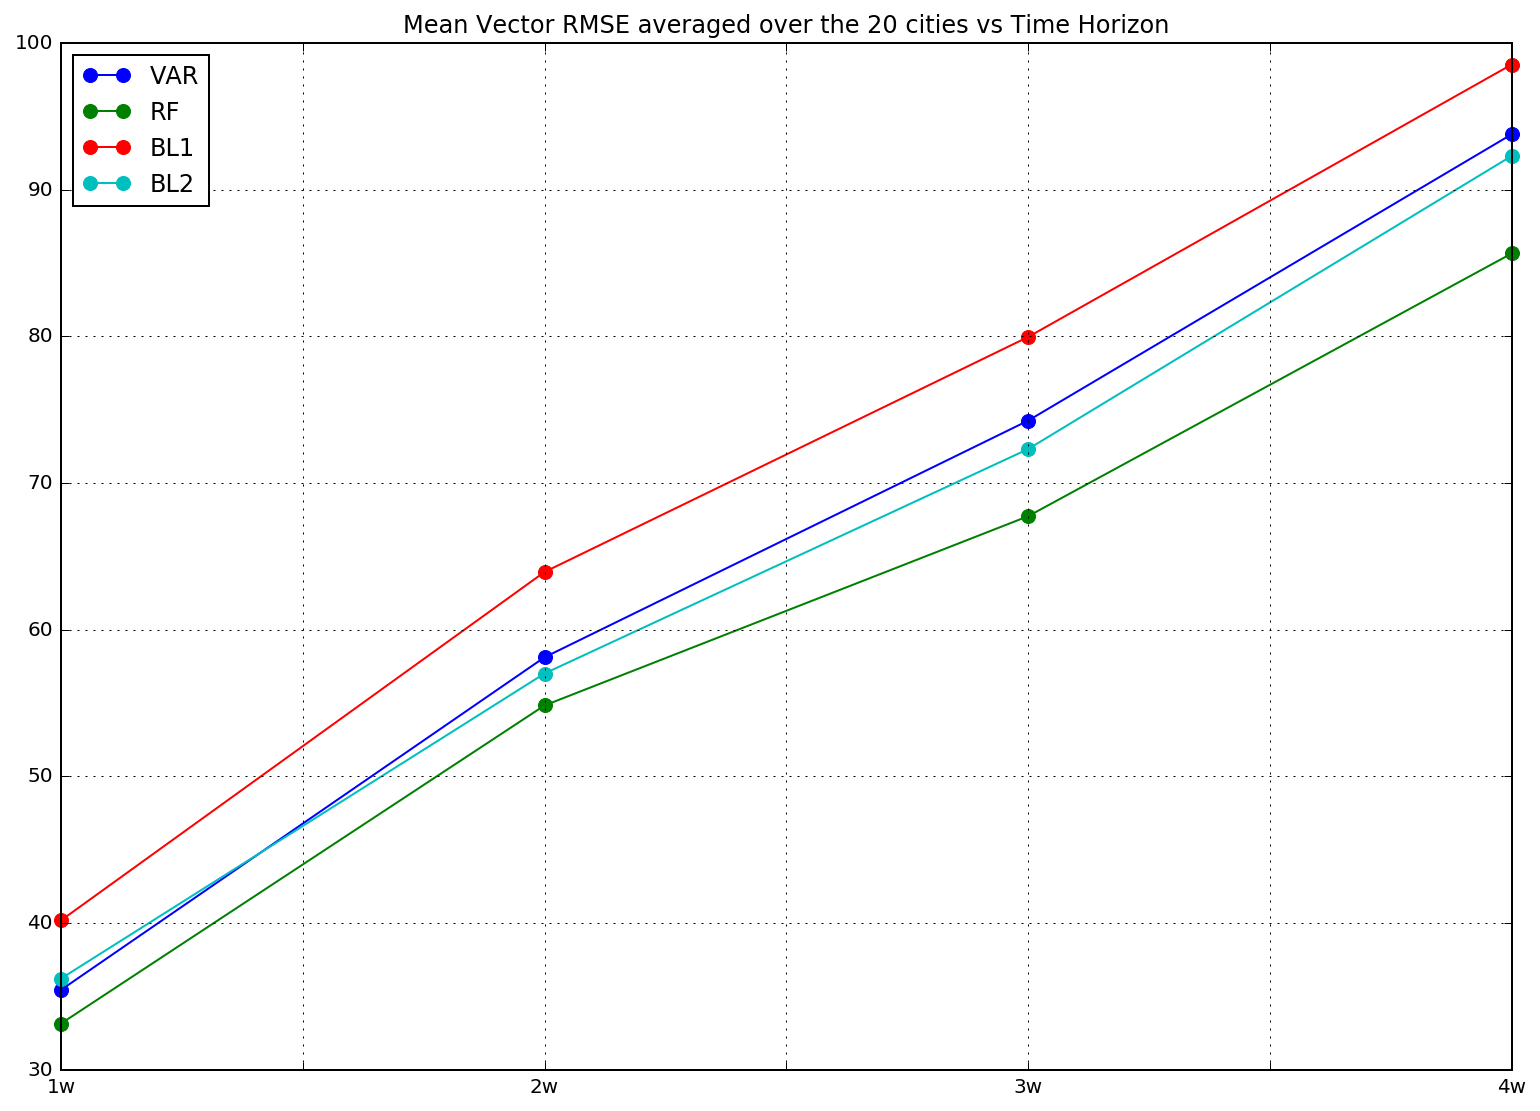

In [22]:
agg.plot(style=".-", grid=True,clip_on=False, ms=14, figsize=(13,9.2));plt.title("Mean Vector RMSE averaged over the 20 cities vs Time Horizon")

Text(0.5, 0.98, 'Normalized RMSE, Time Horizon : 1w, variable : new_mapper')

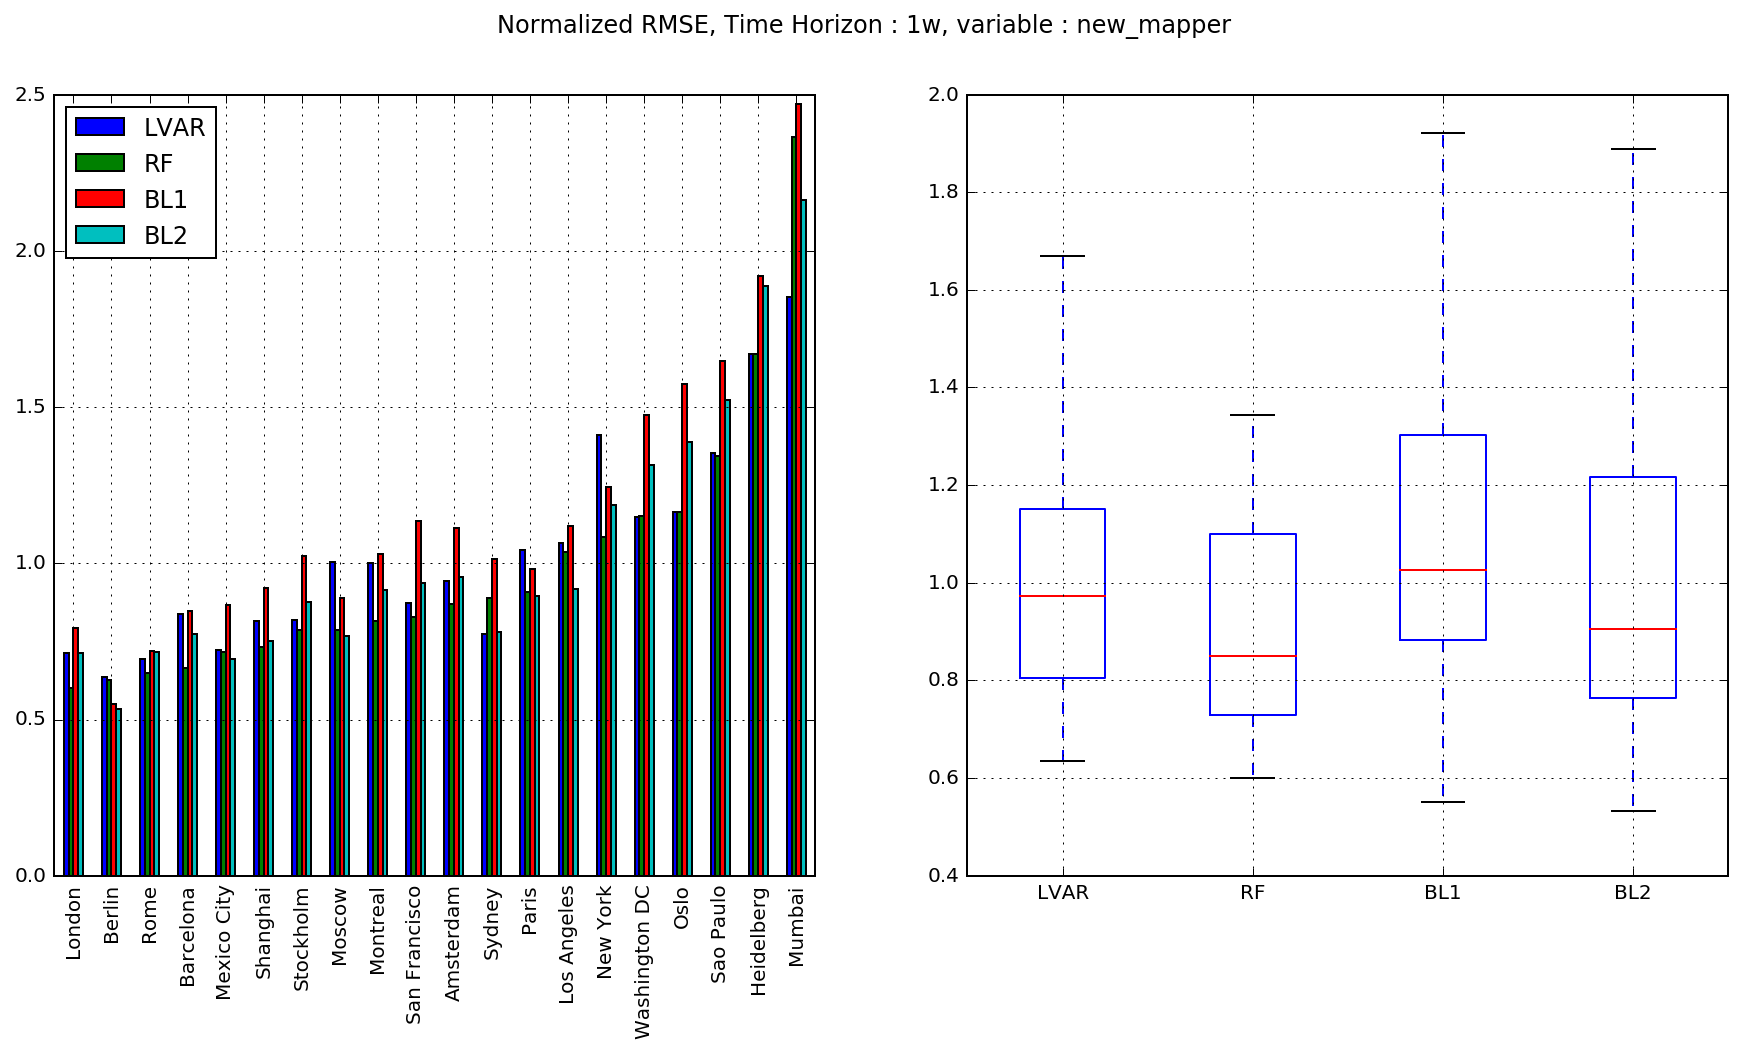

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
city_performance("w", "new_mapper").sort_values(by="RF").plot.bar(grid=True, ax=axes[0])
city_performance("w", "new_mapper").boxplot(showfliers=False, ax=axes[1])
fig.suptitle('Normalized RMSE, Time Horizon : 1w, variable : new_mapper', fontsize=12)

In [26]:
plt.style.use("seaborn")

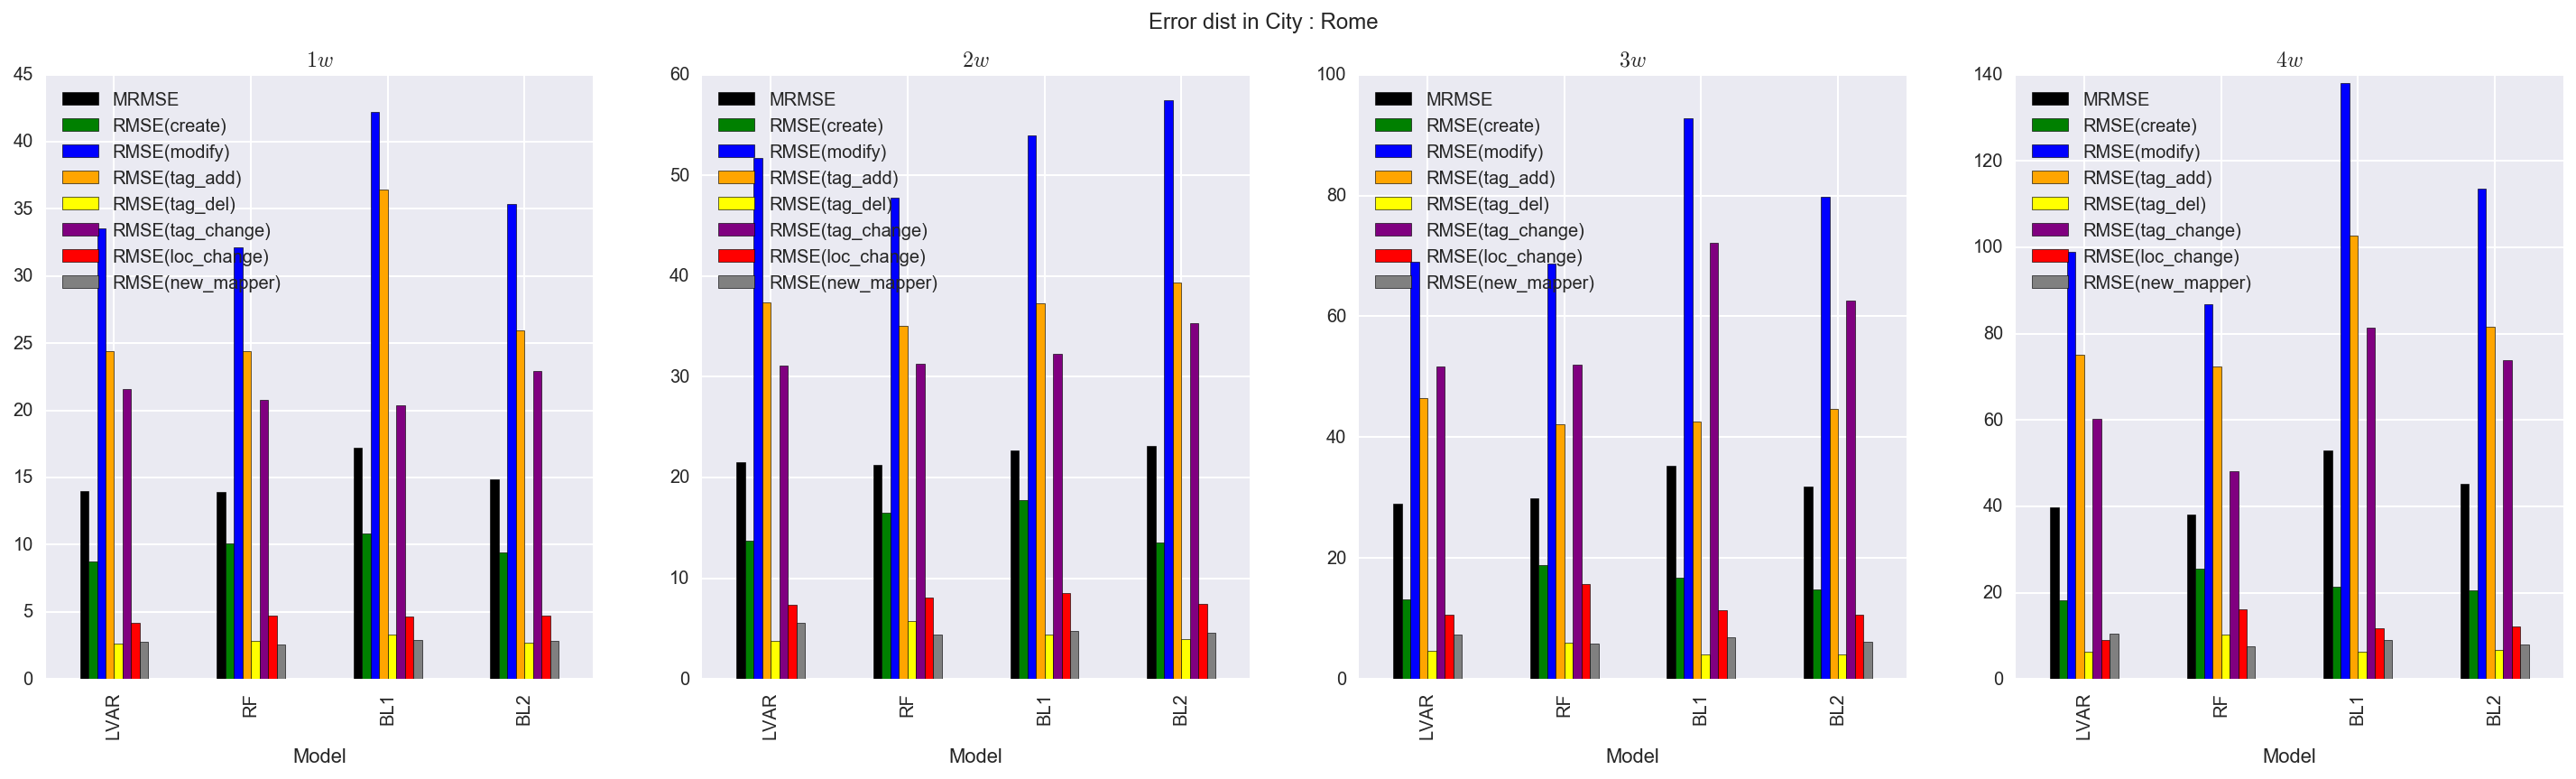

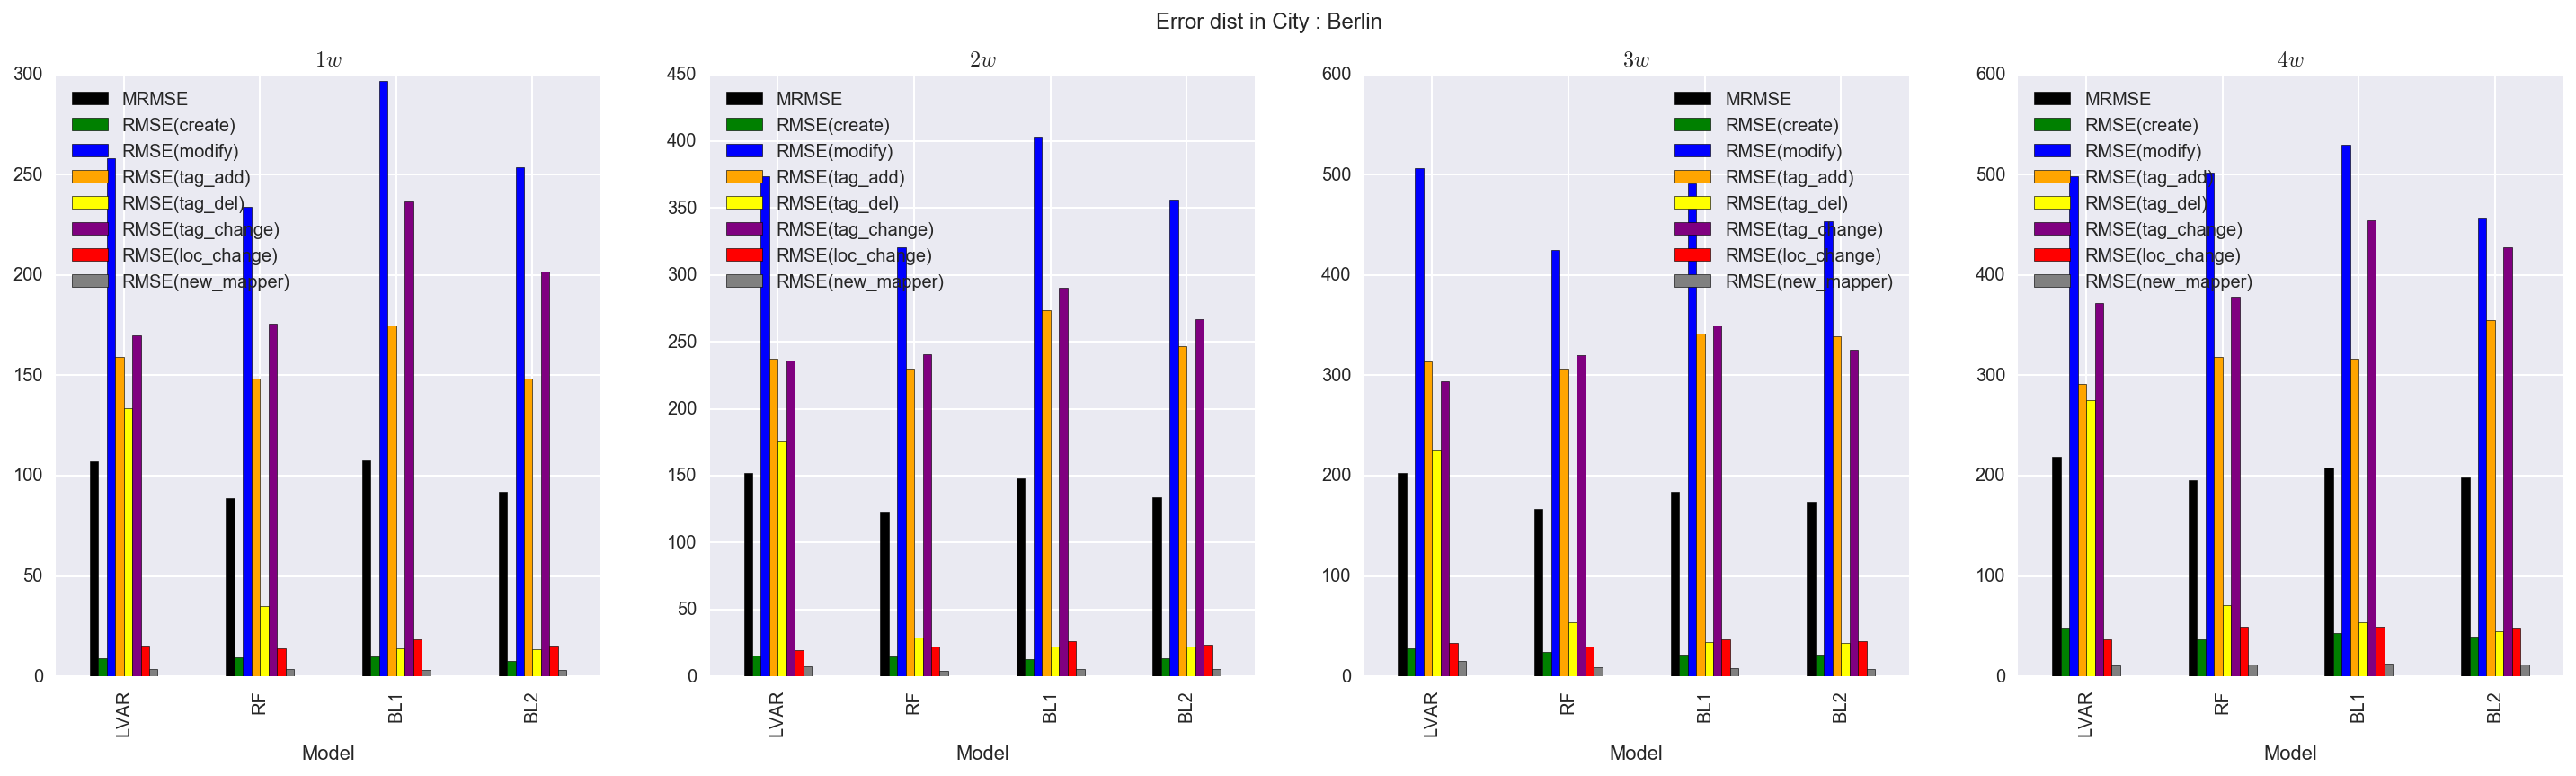

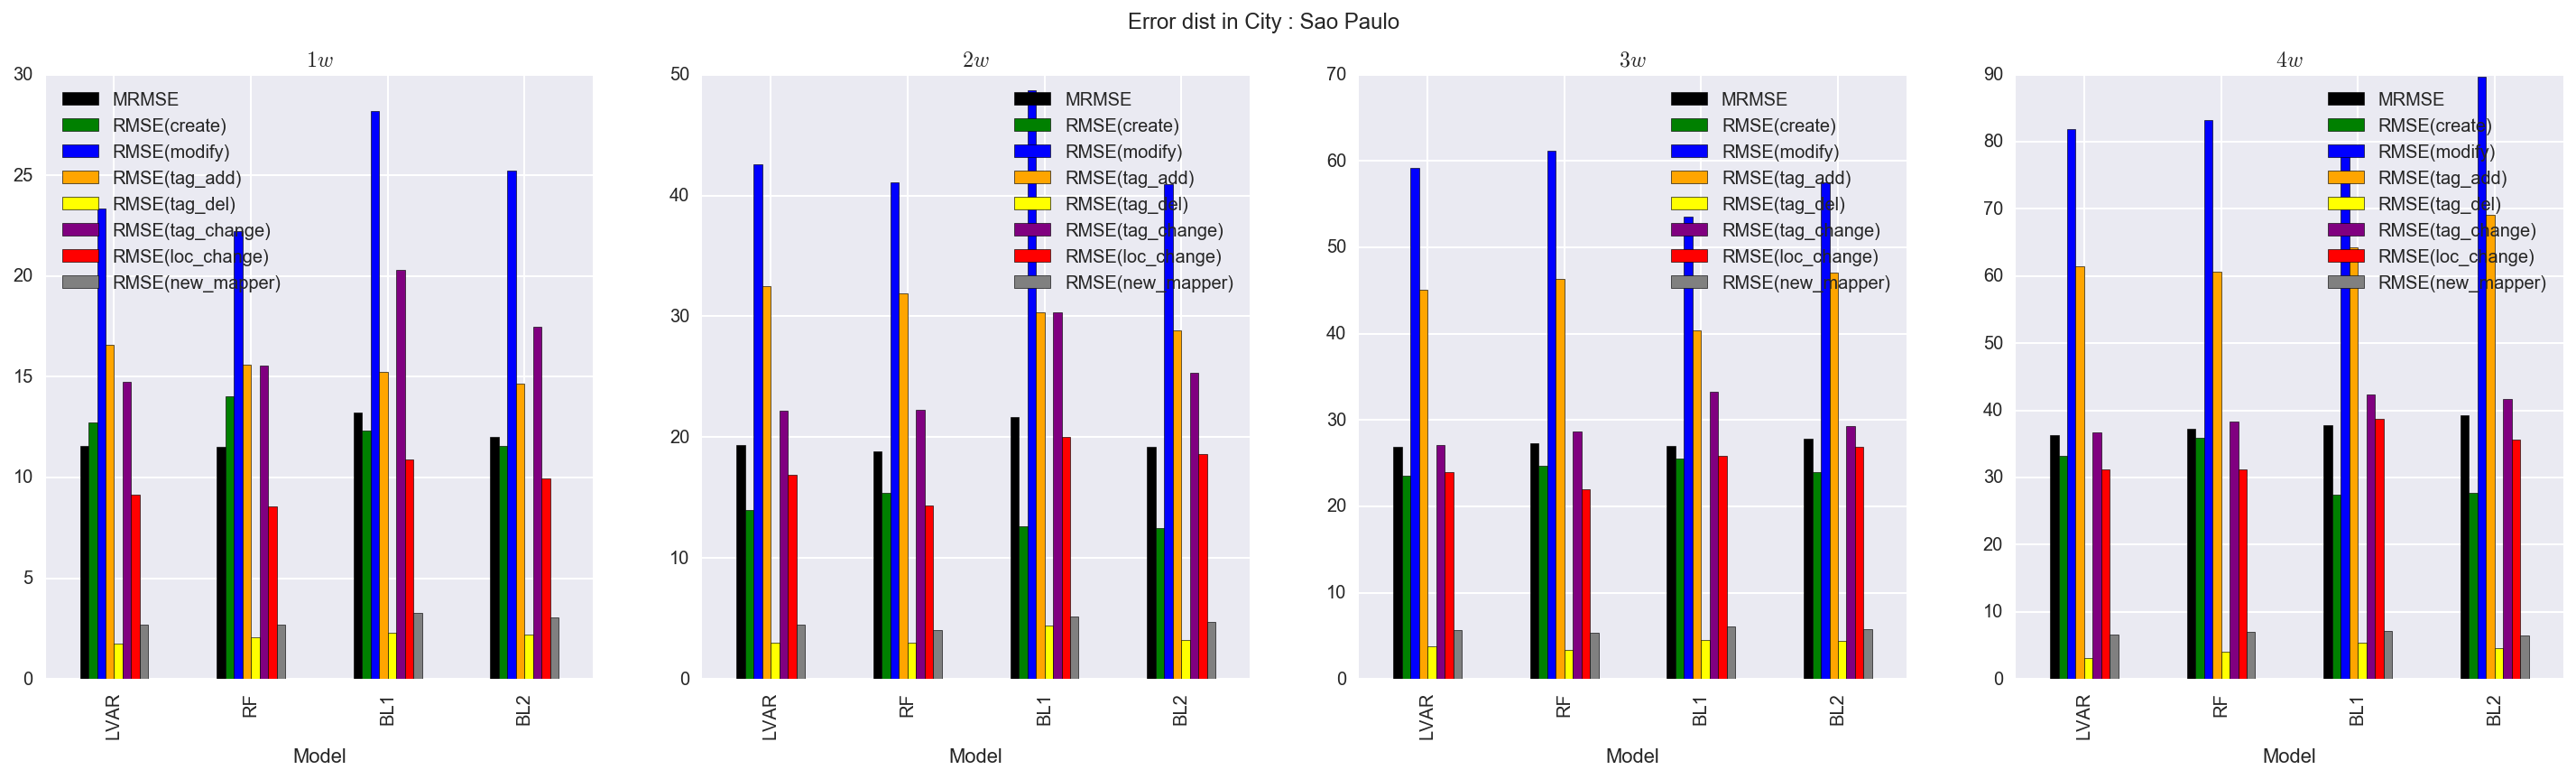

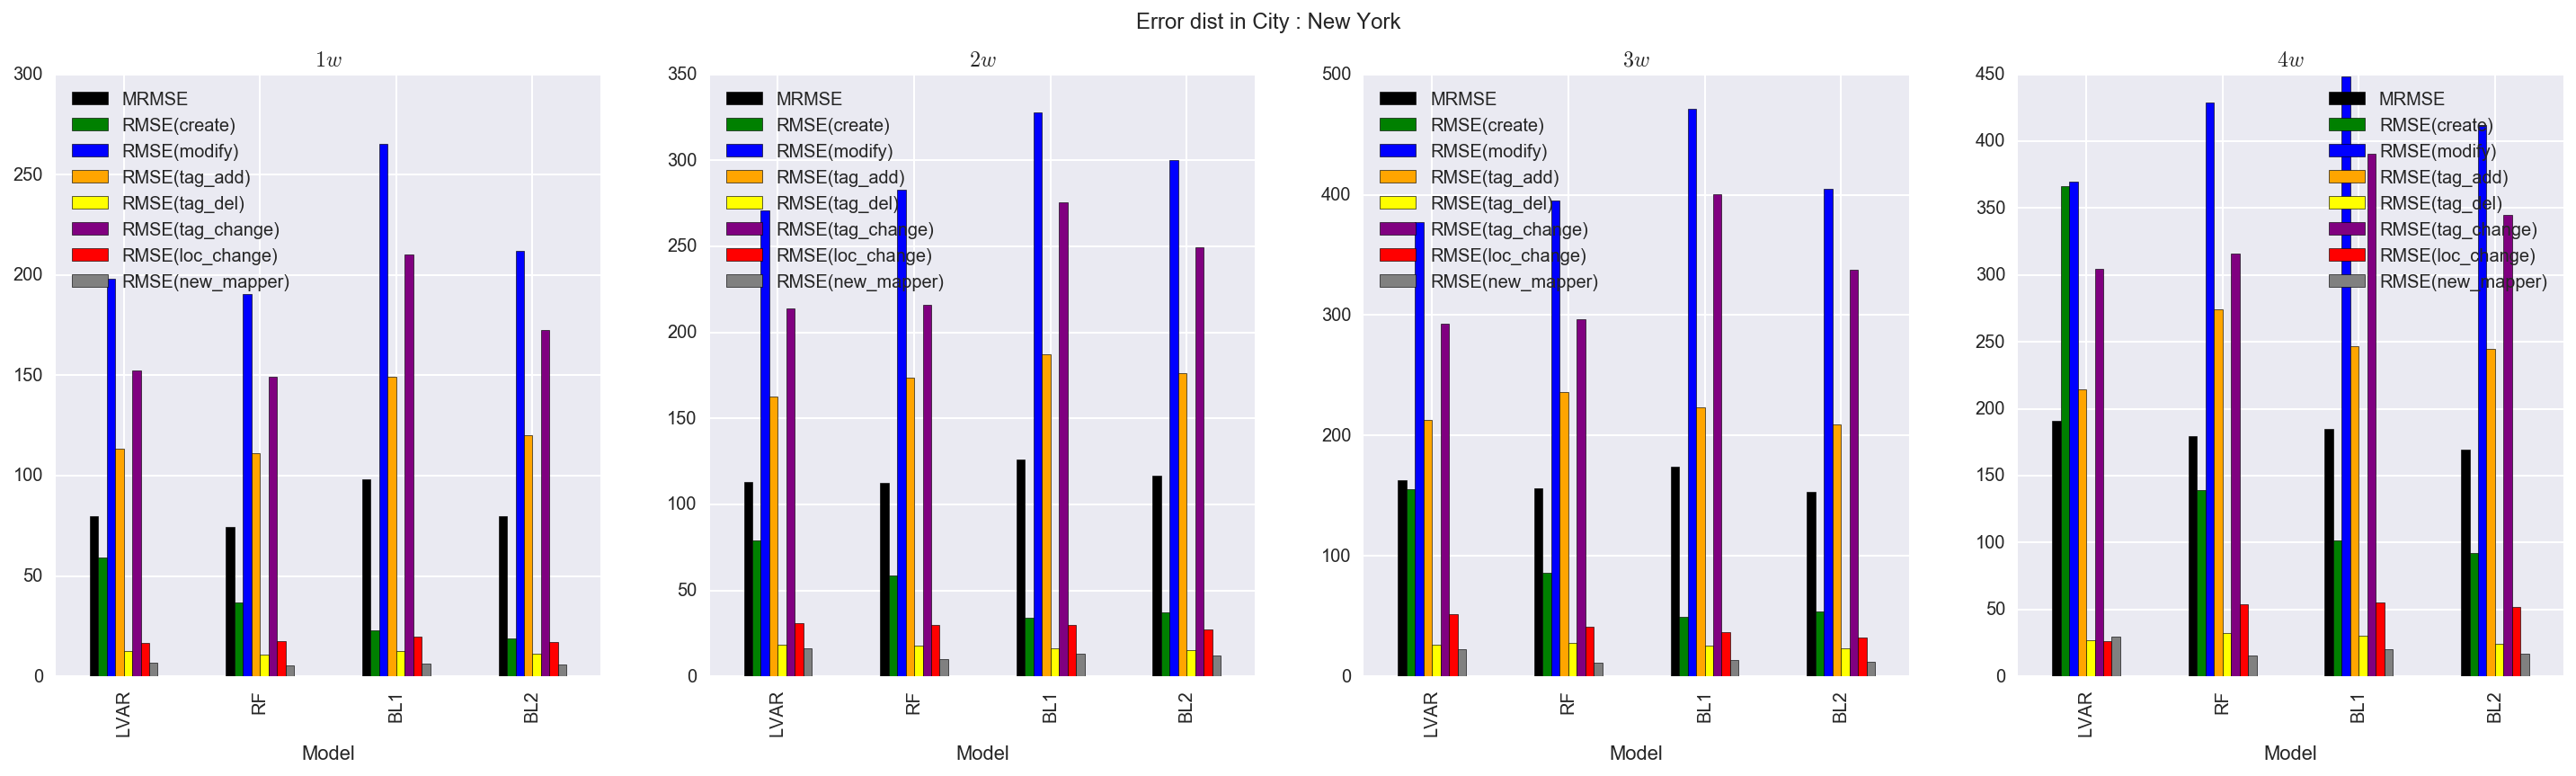

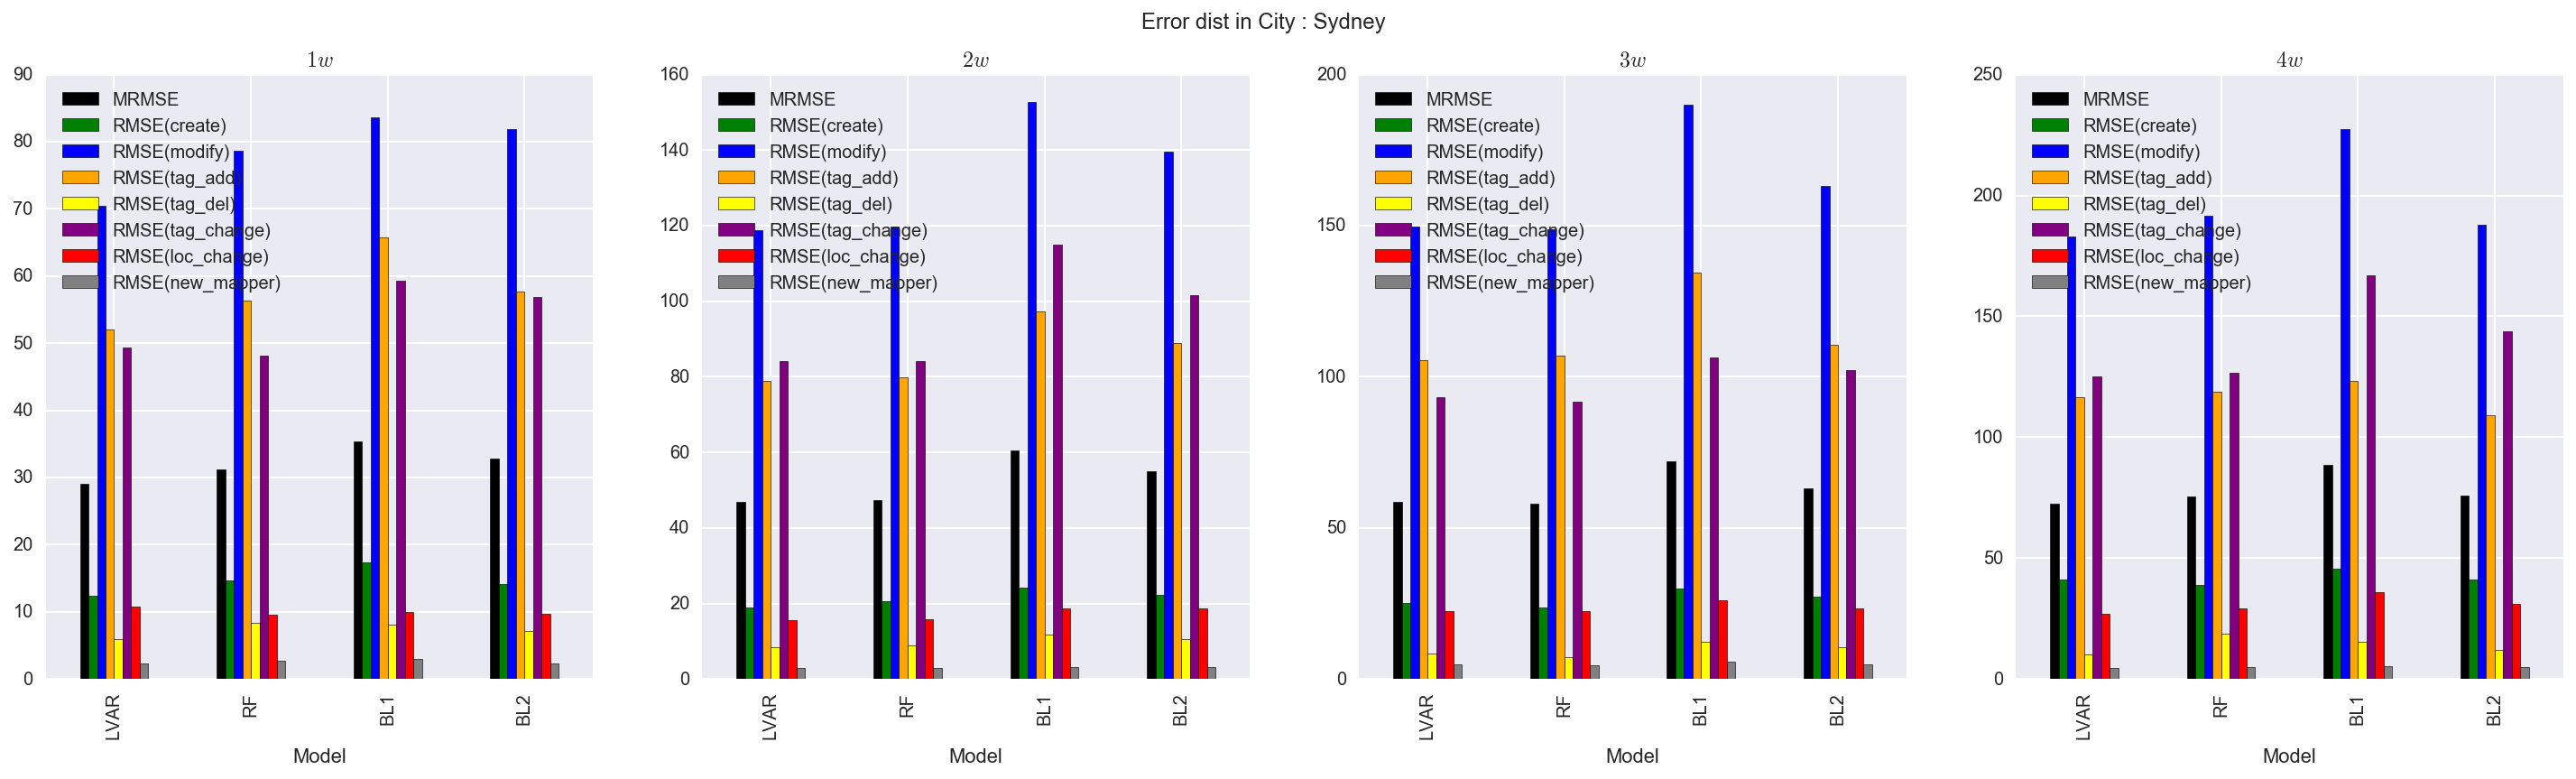

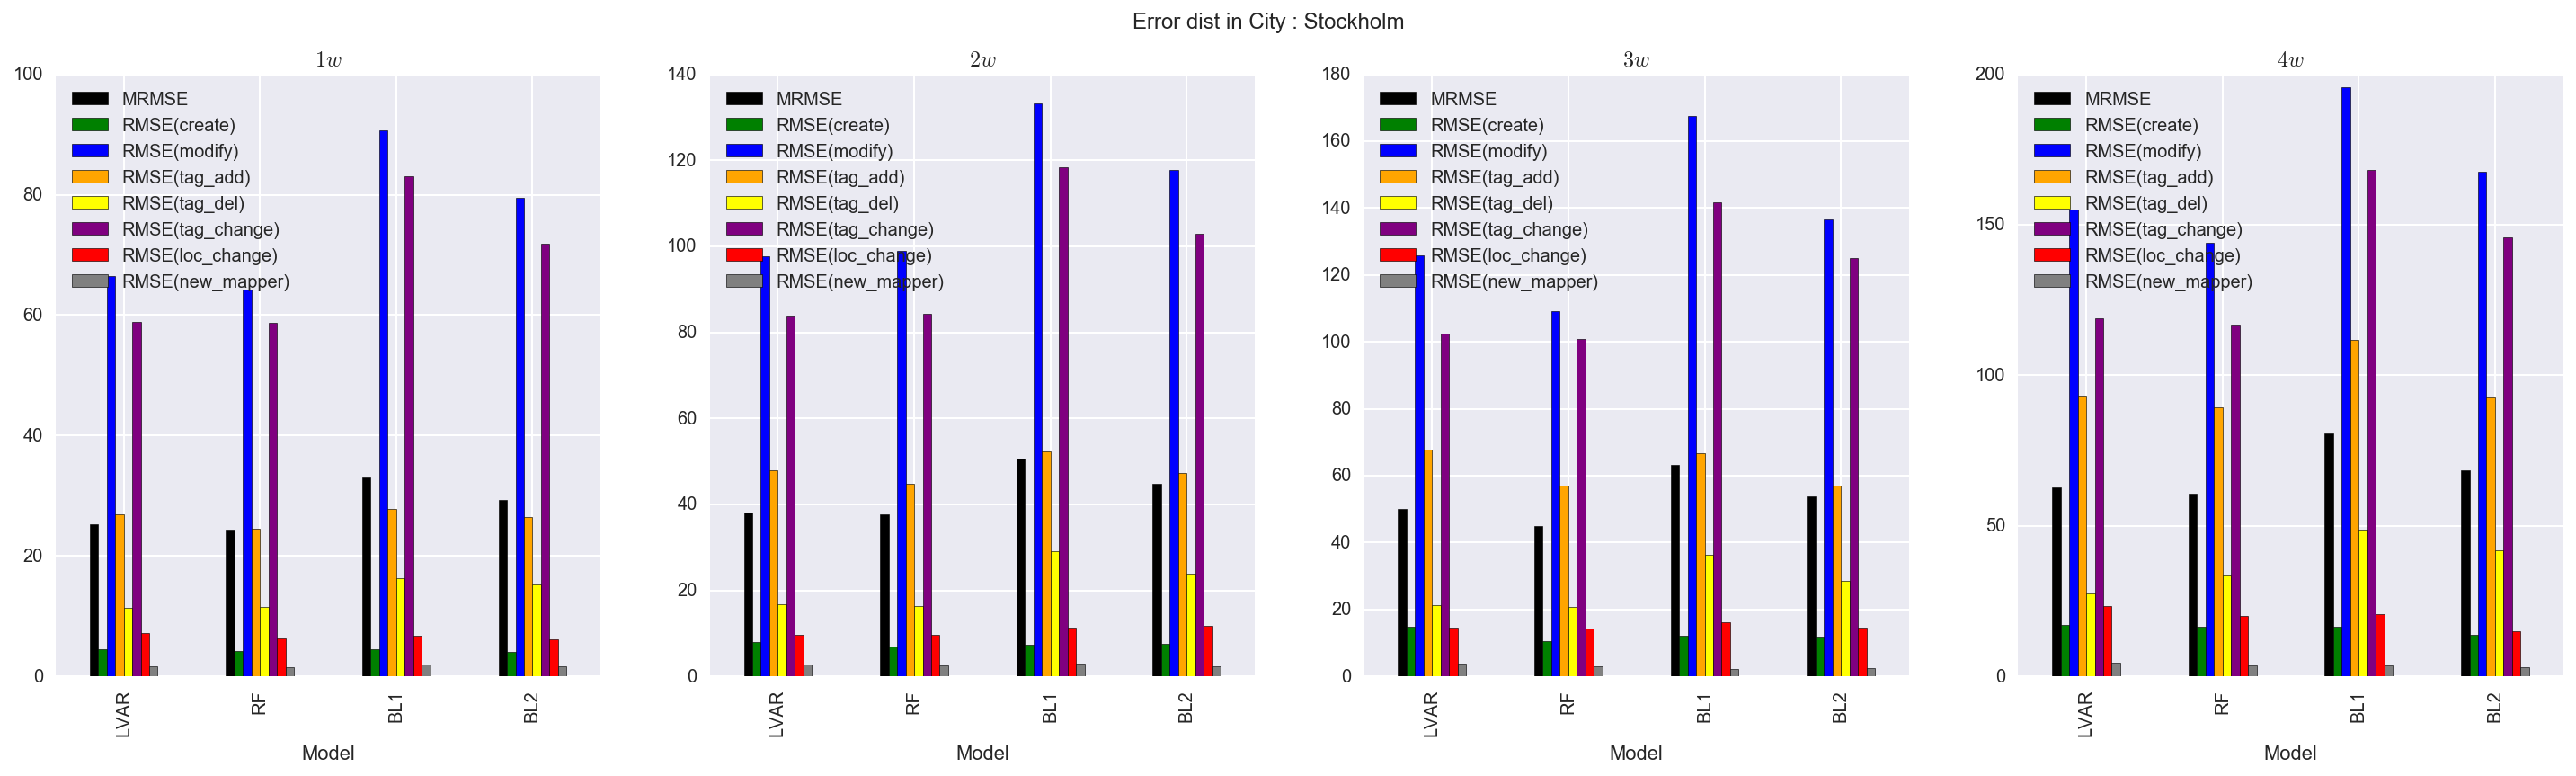

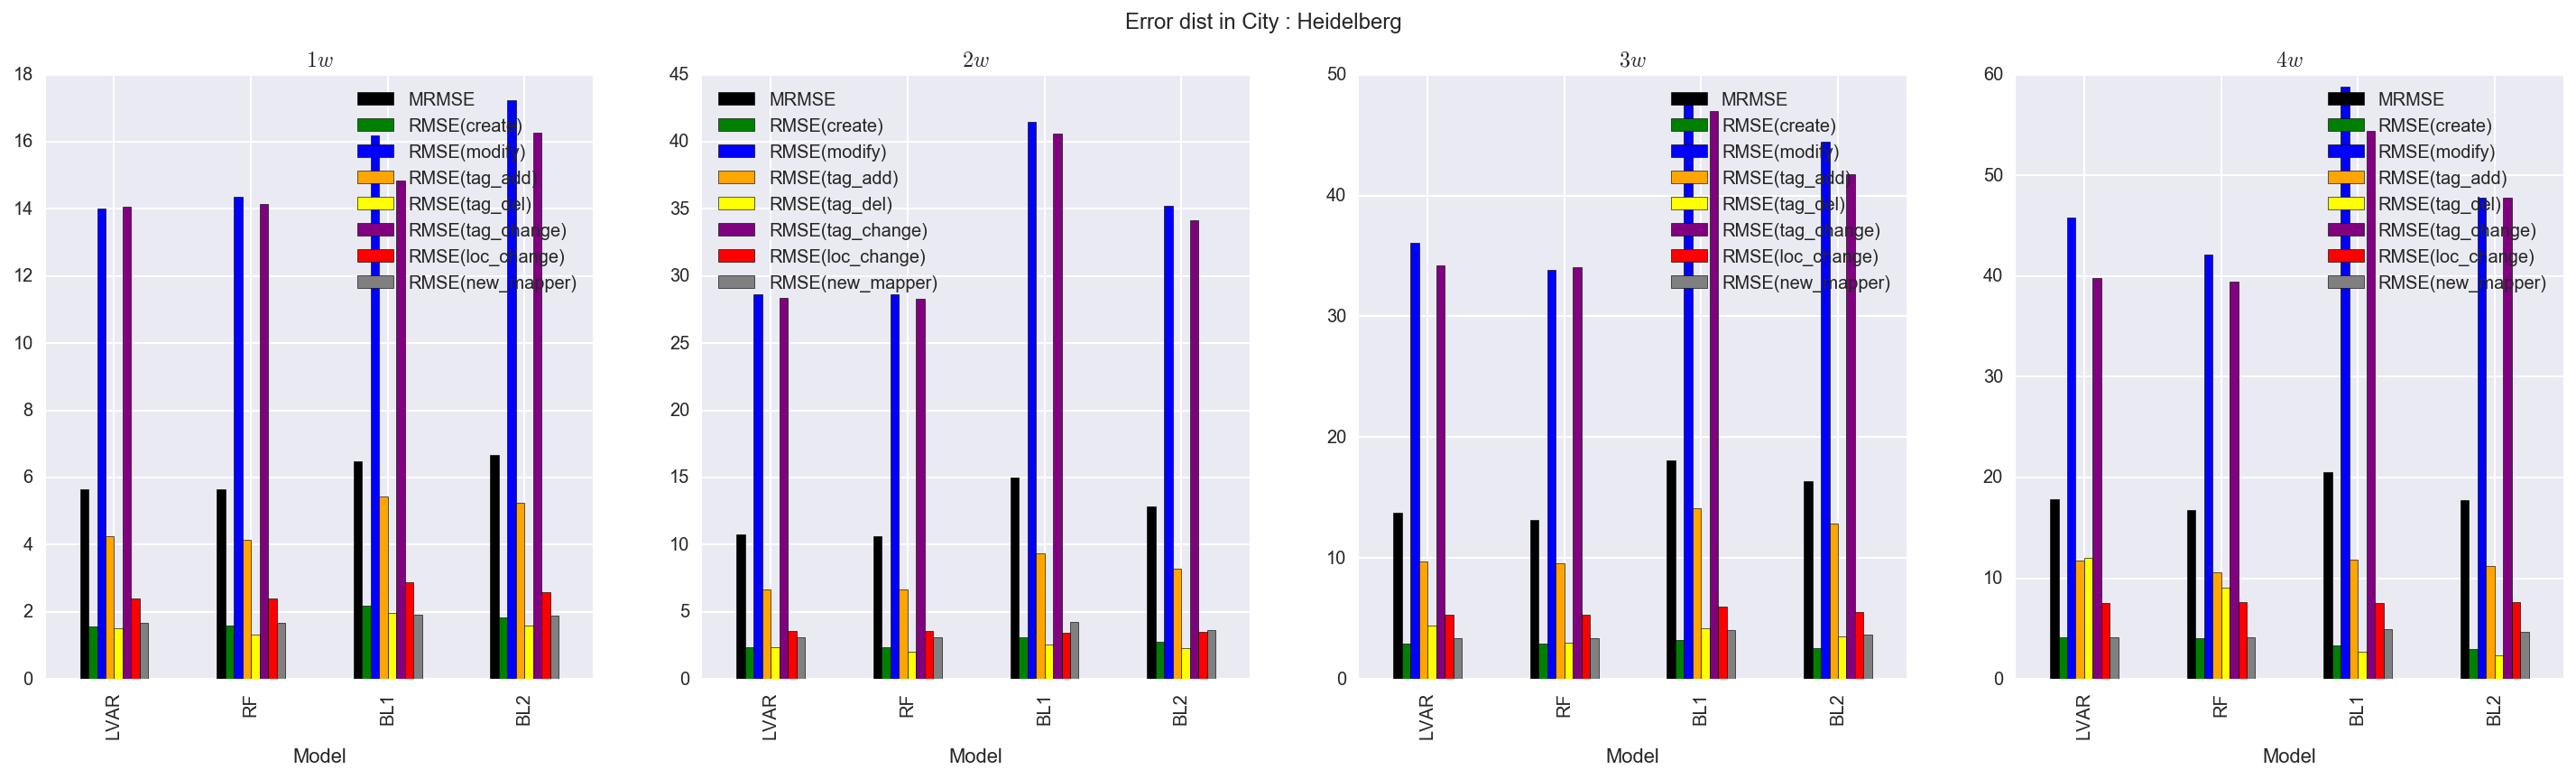

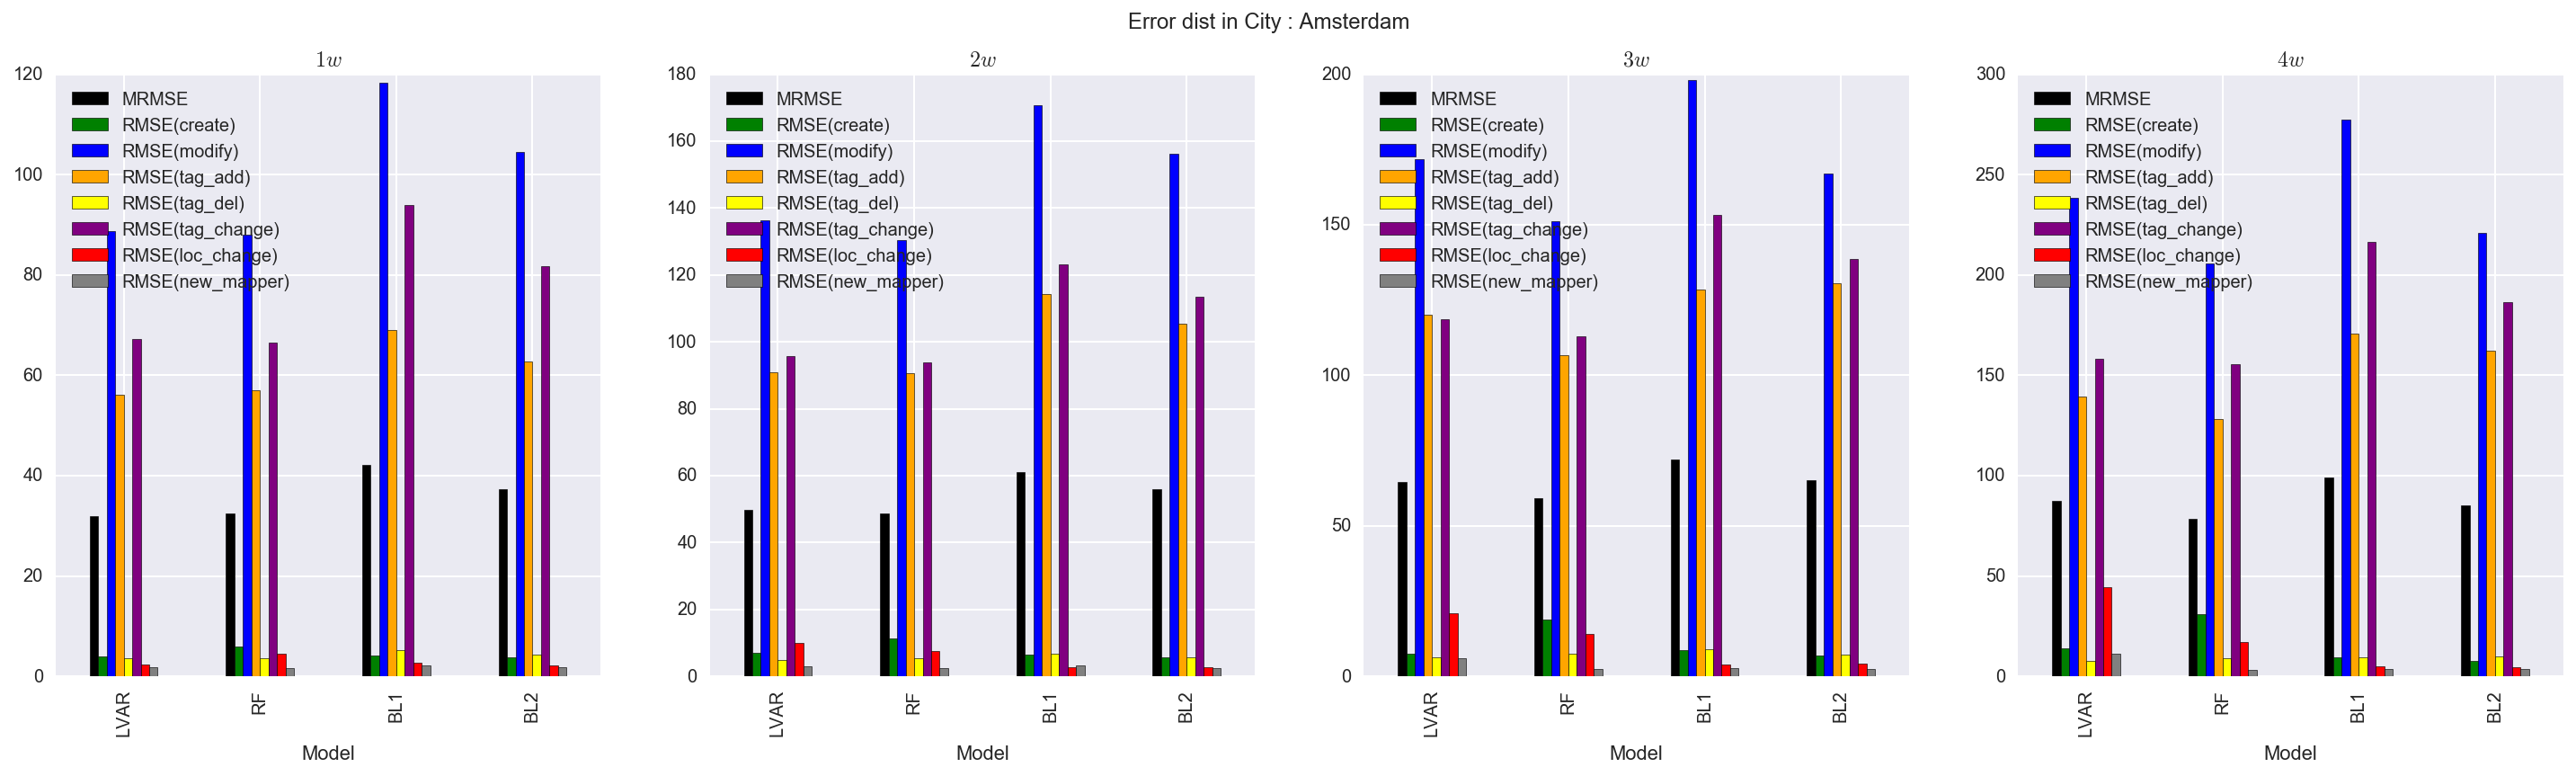

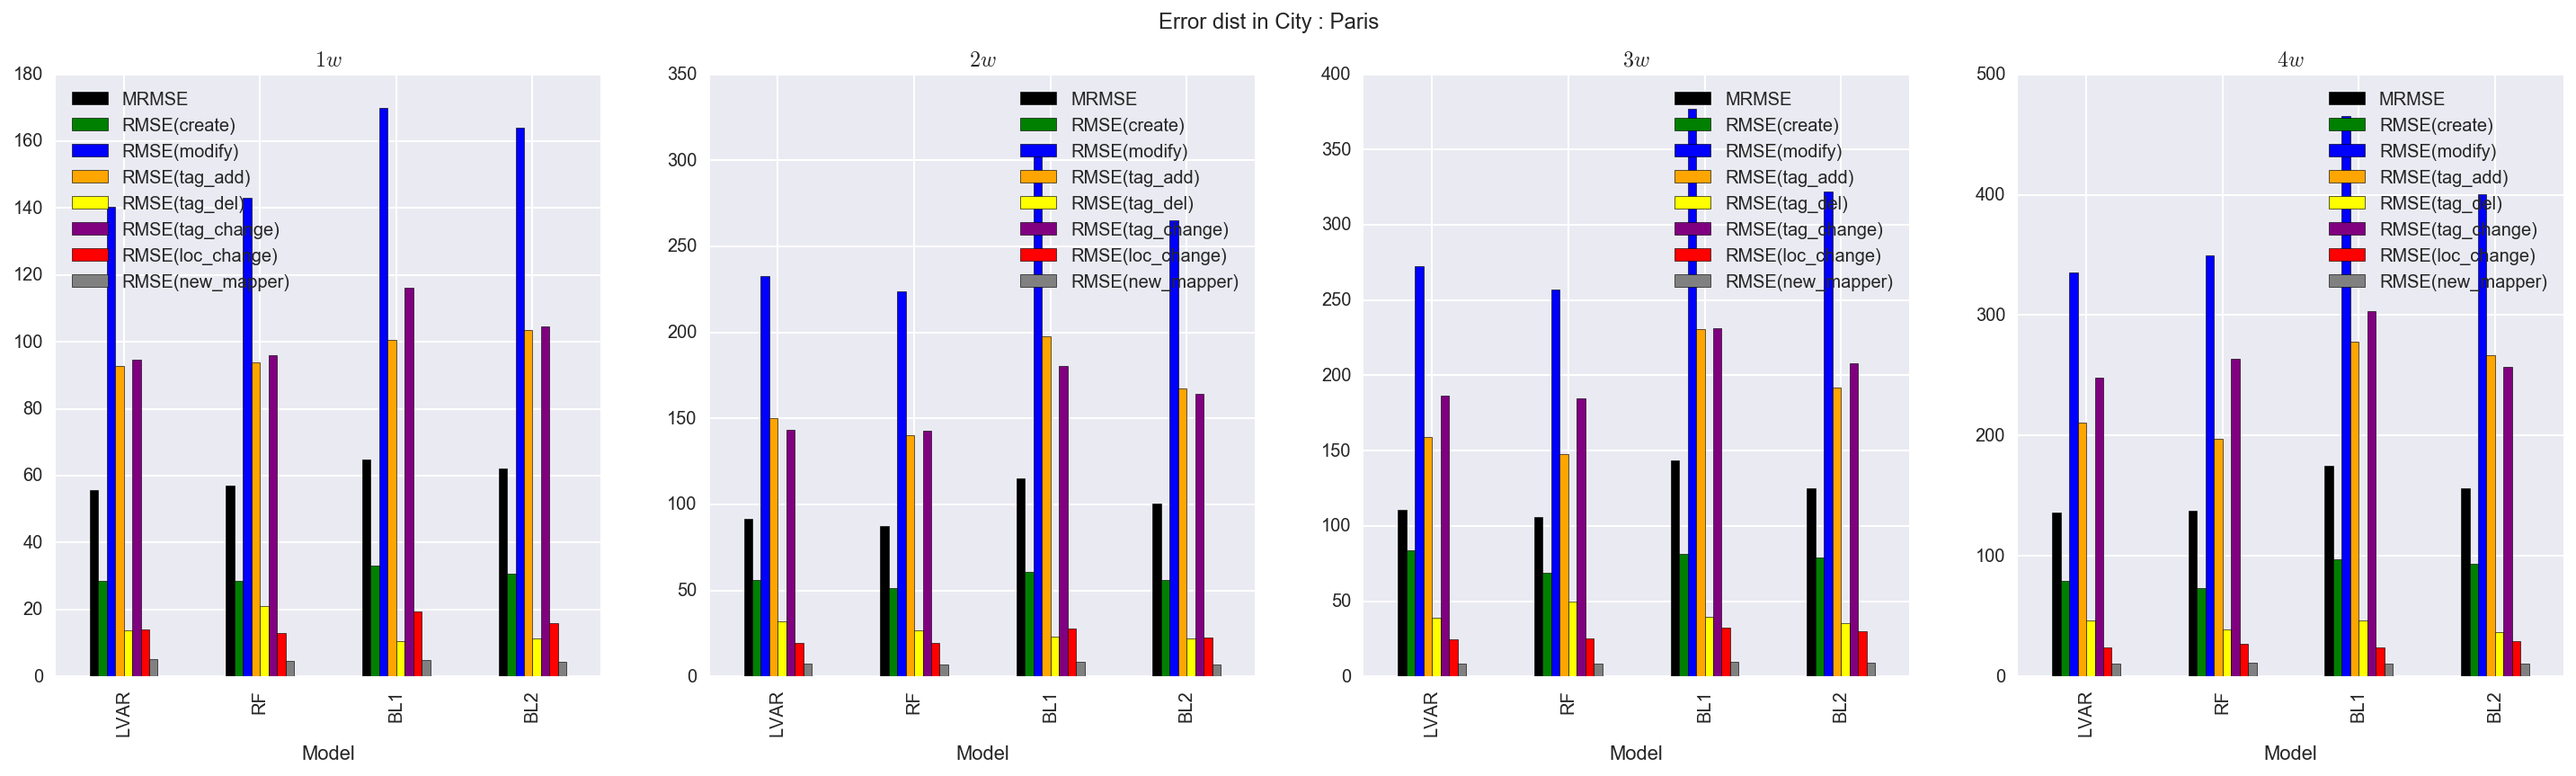

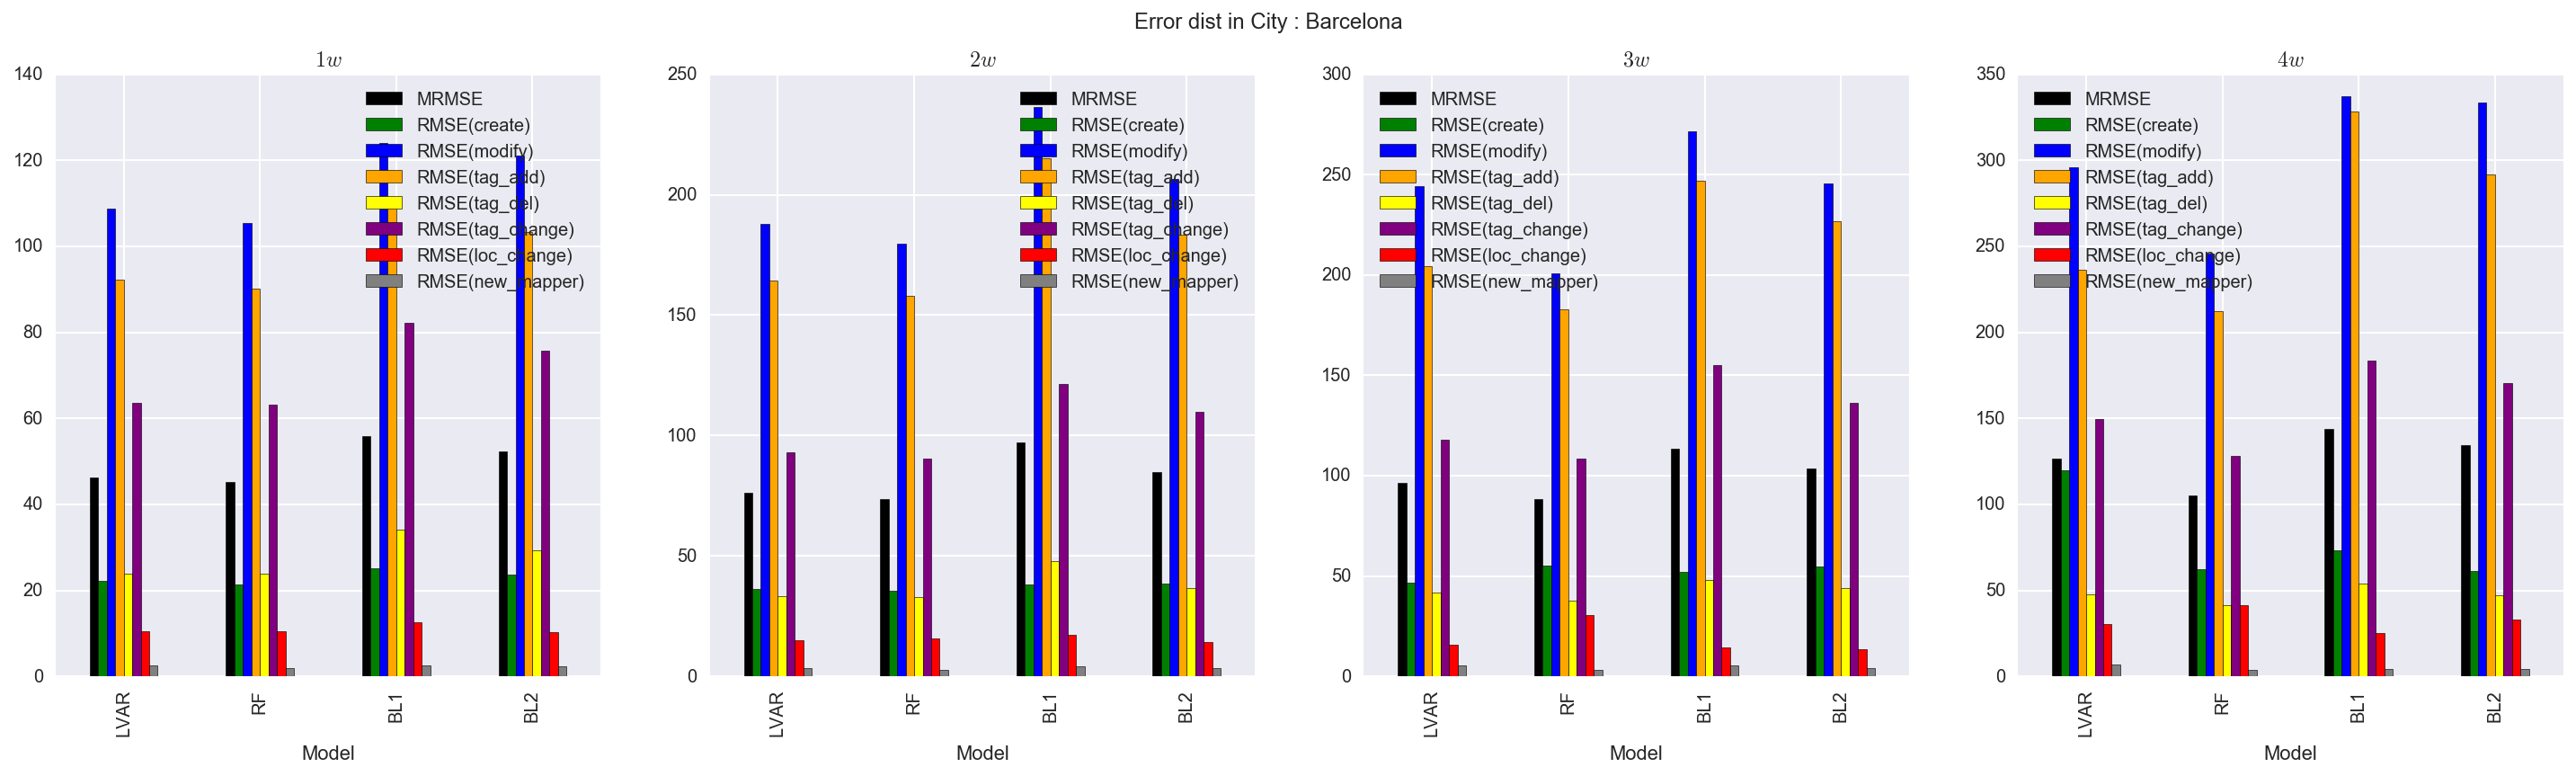

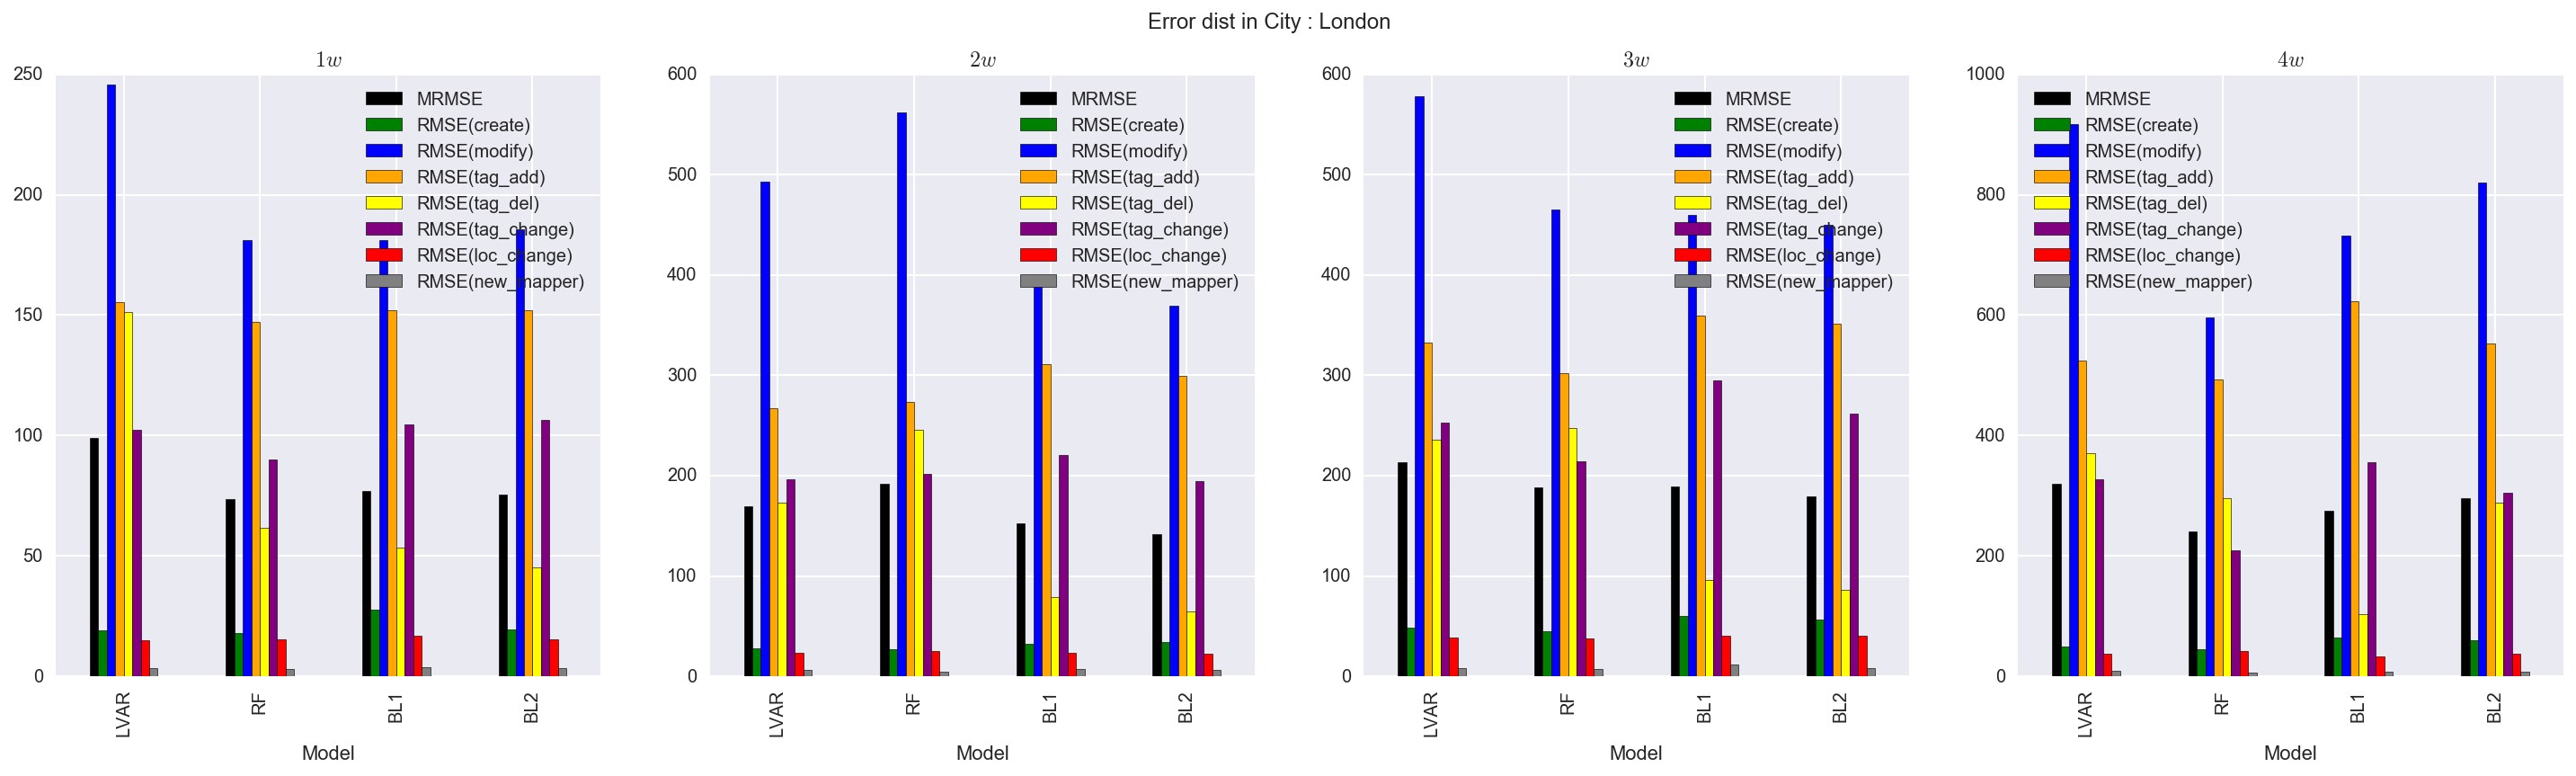

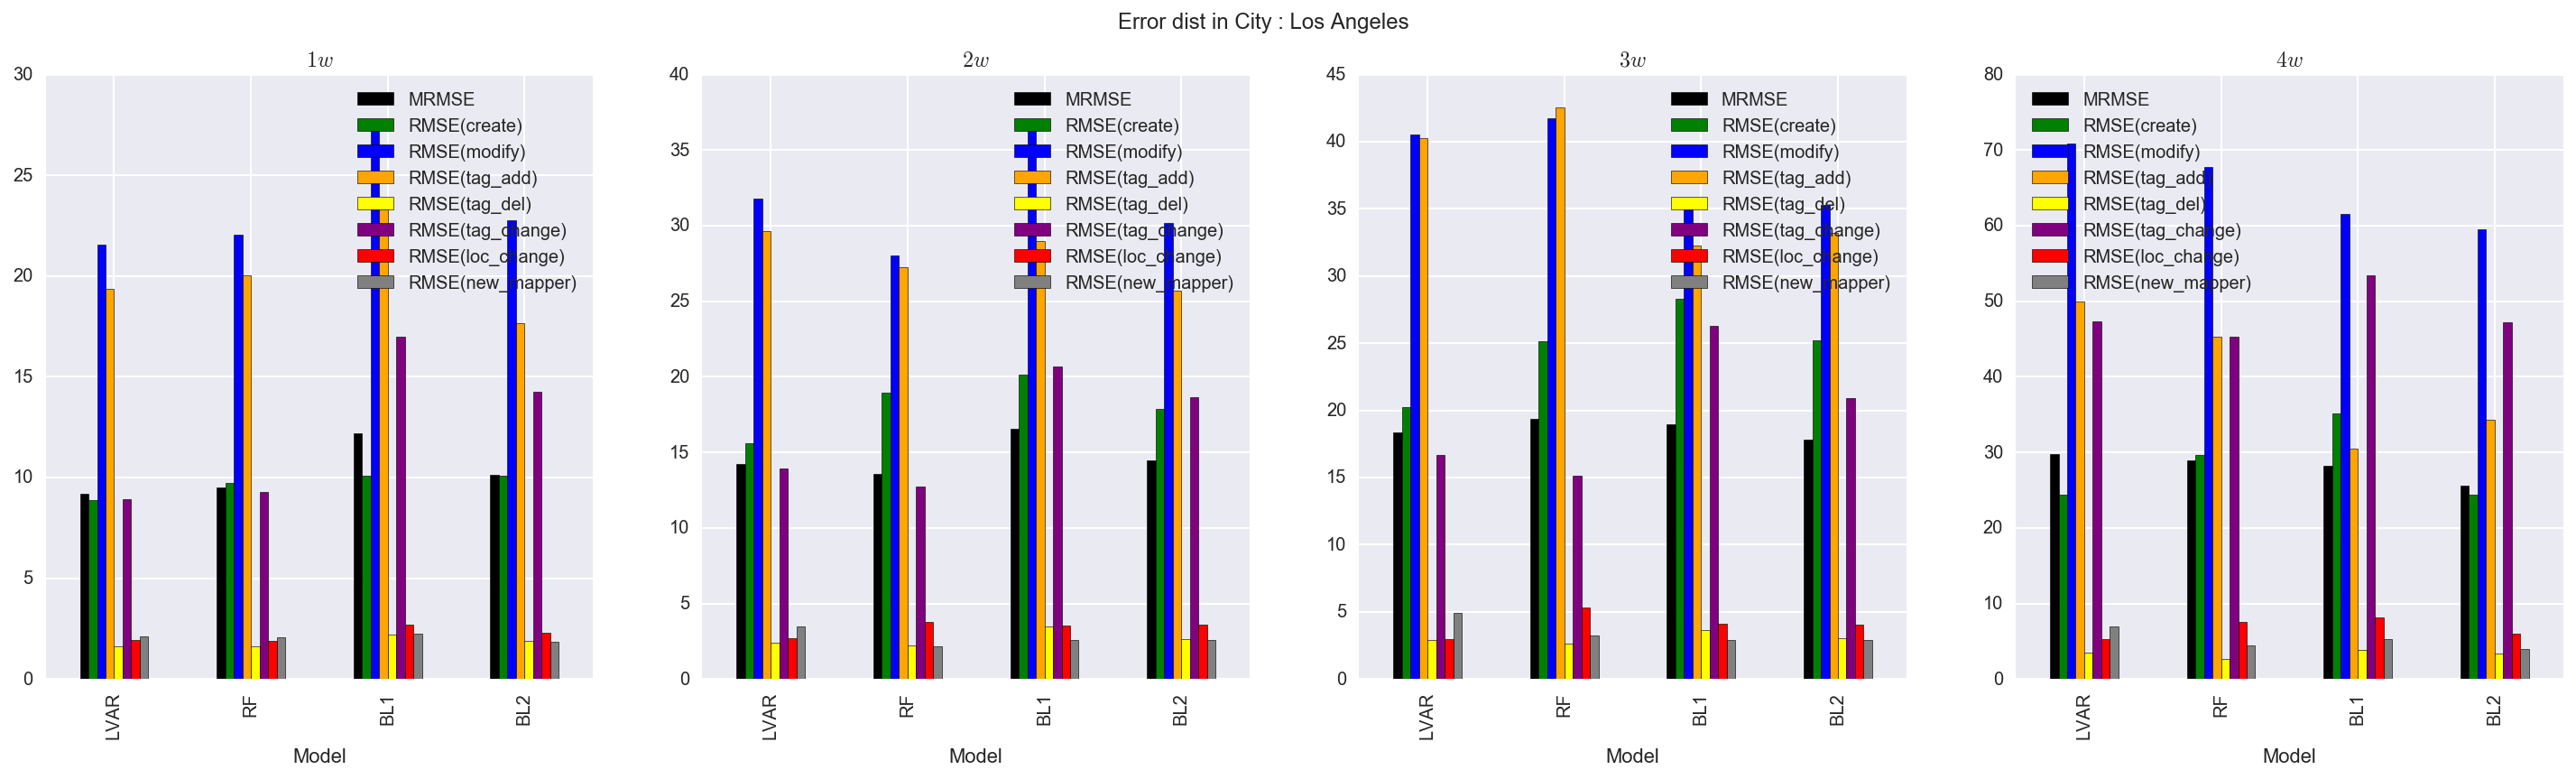

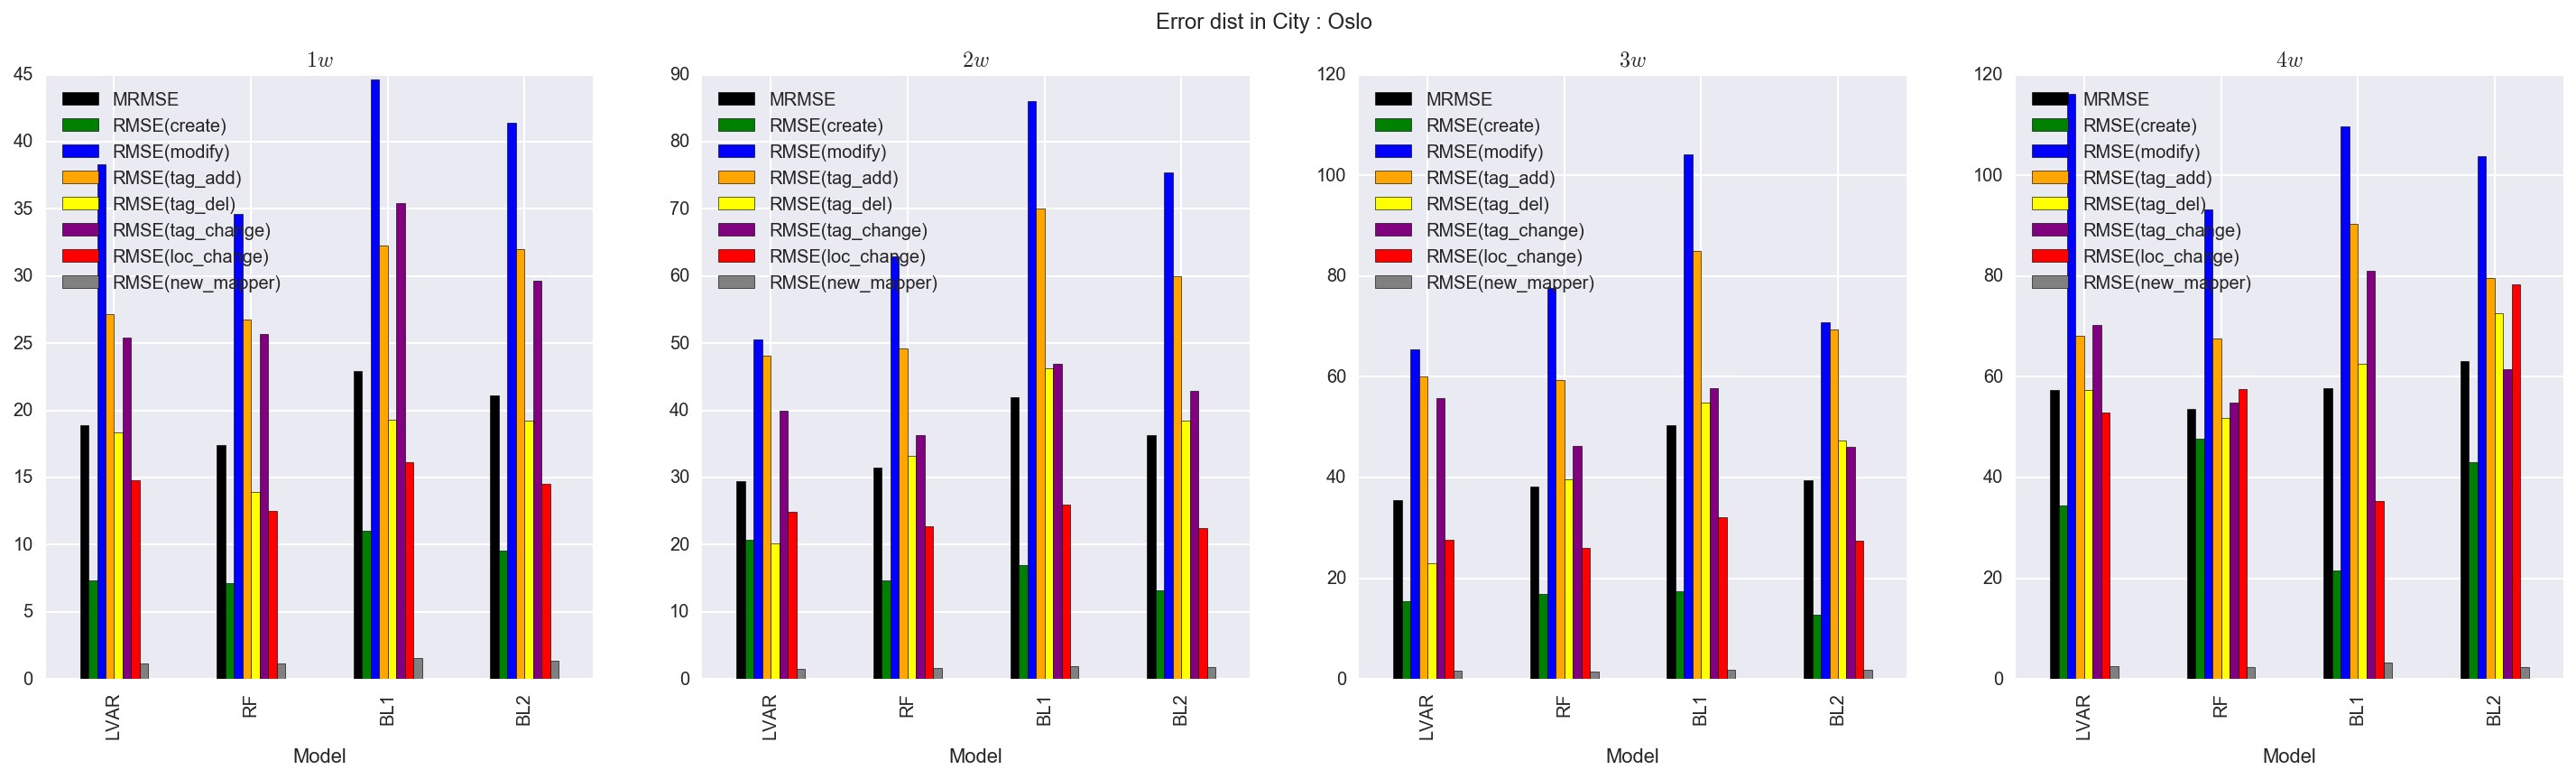

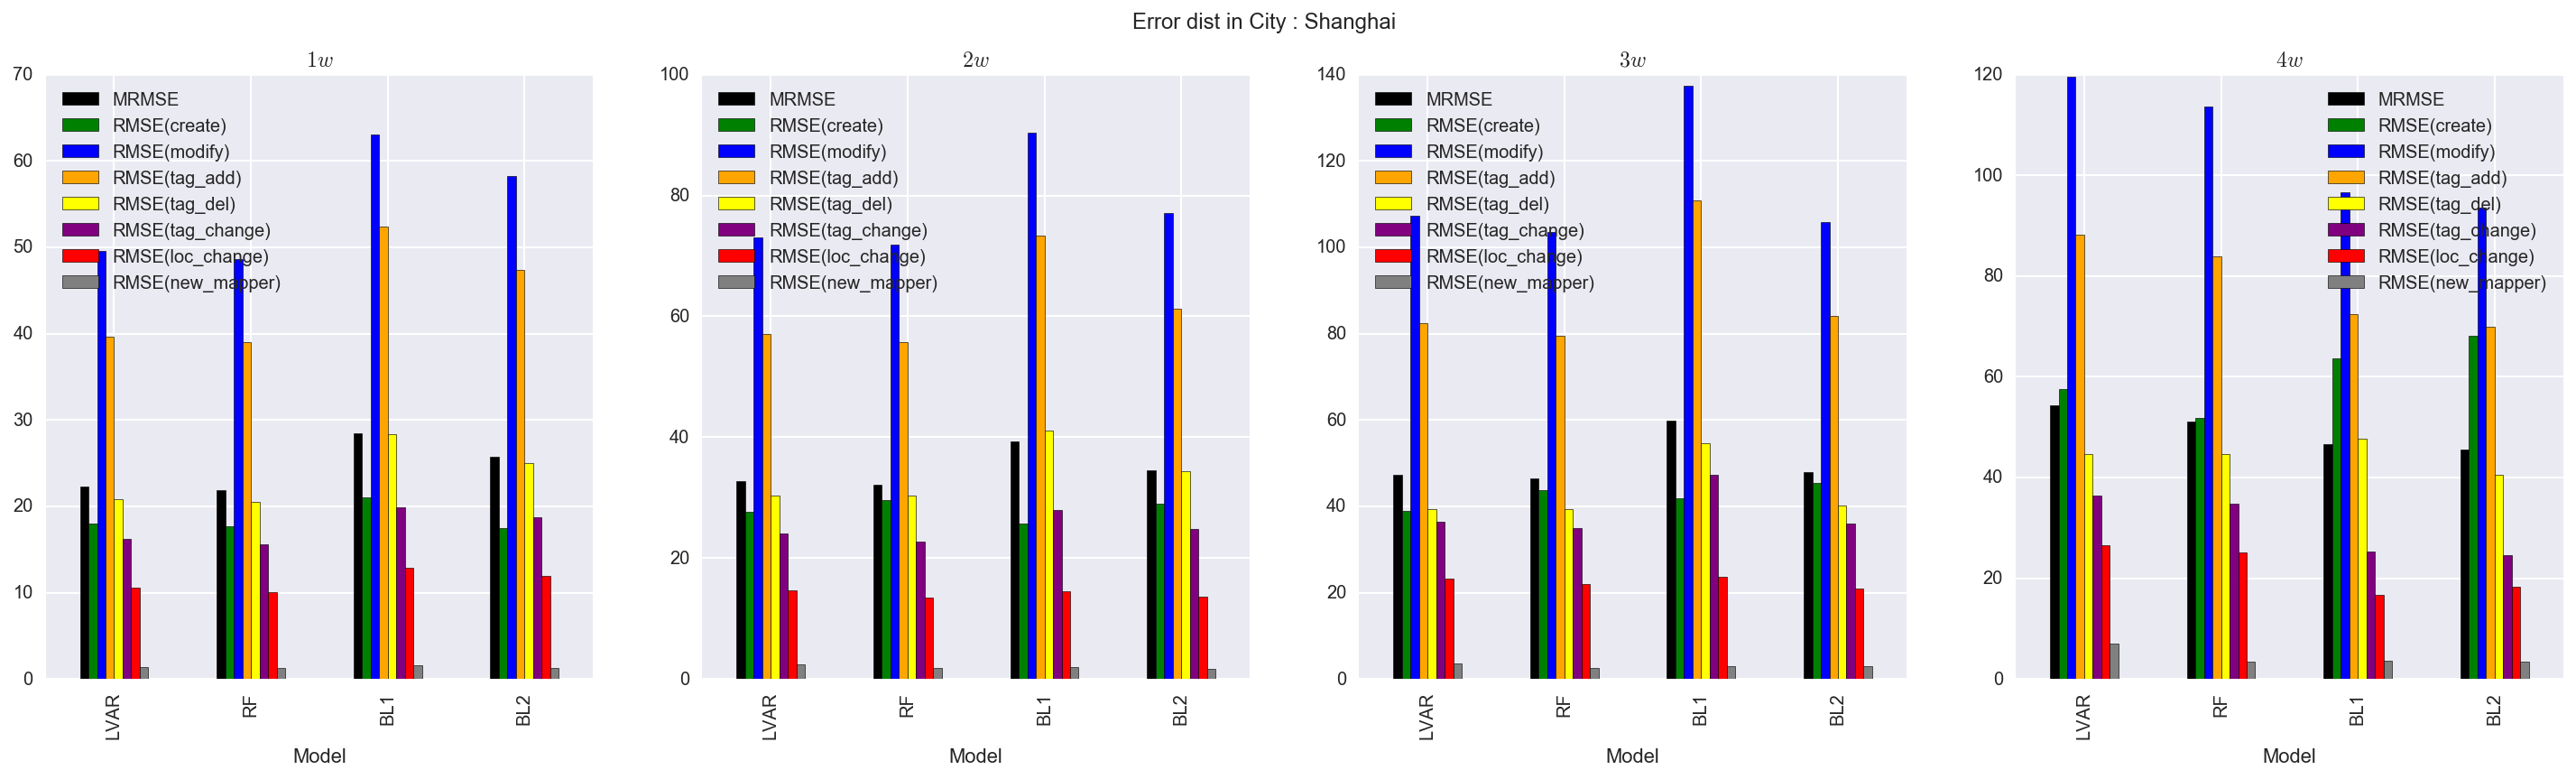

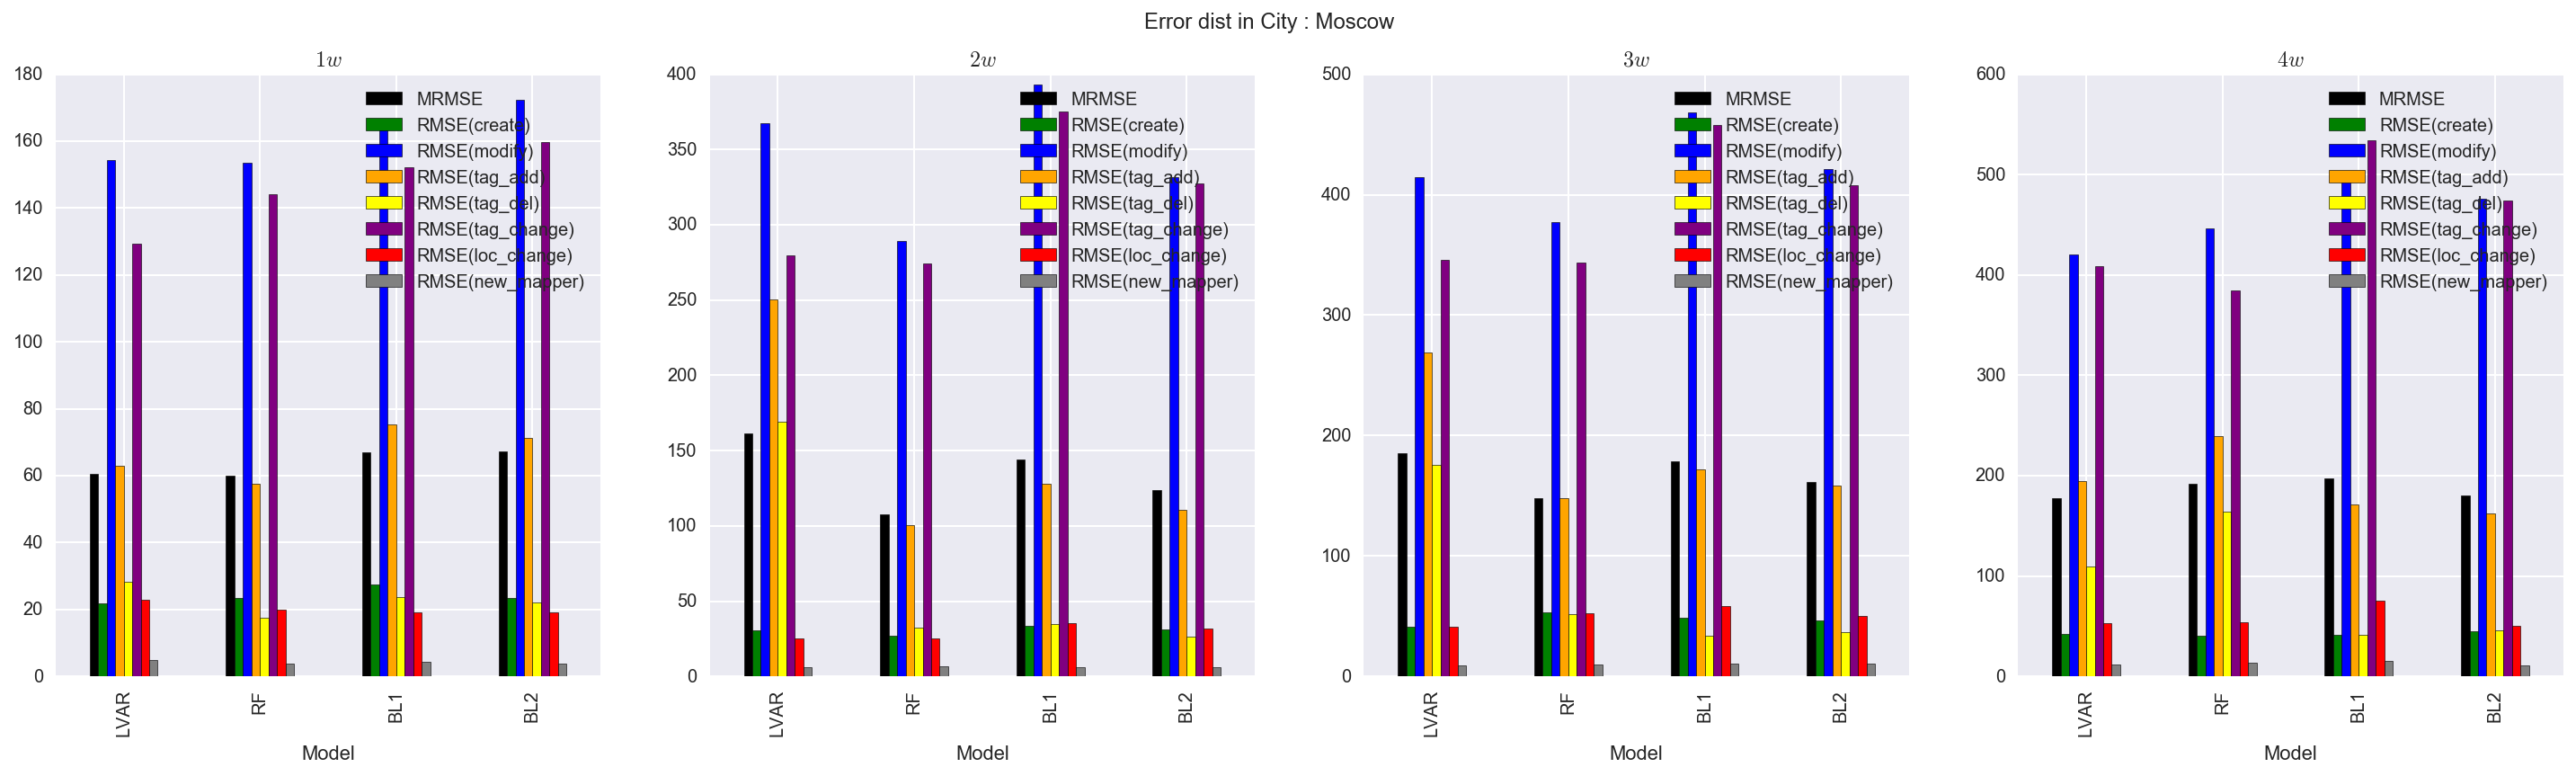

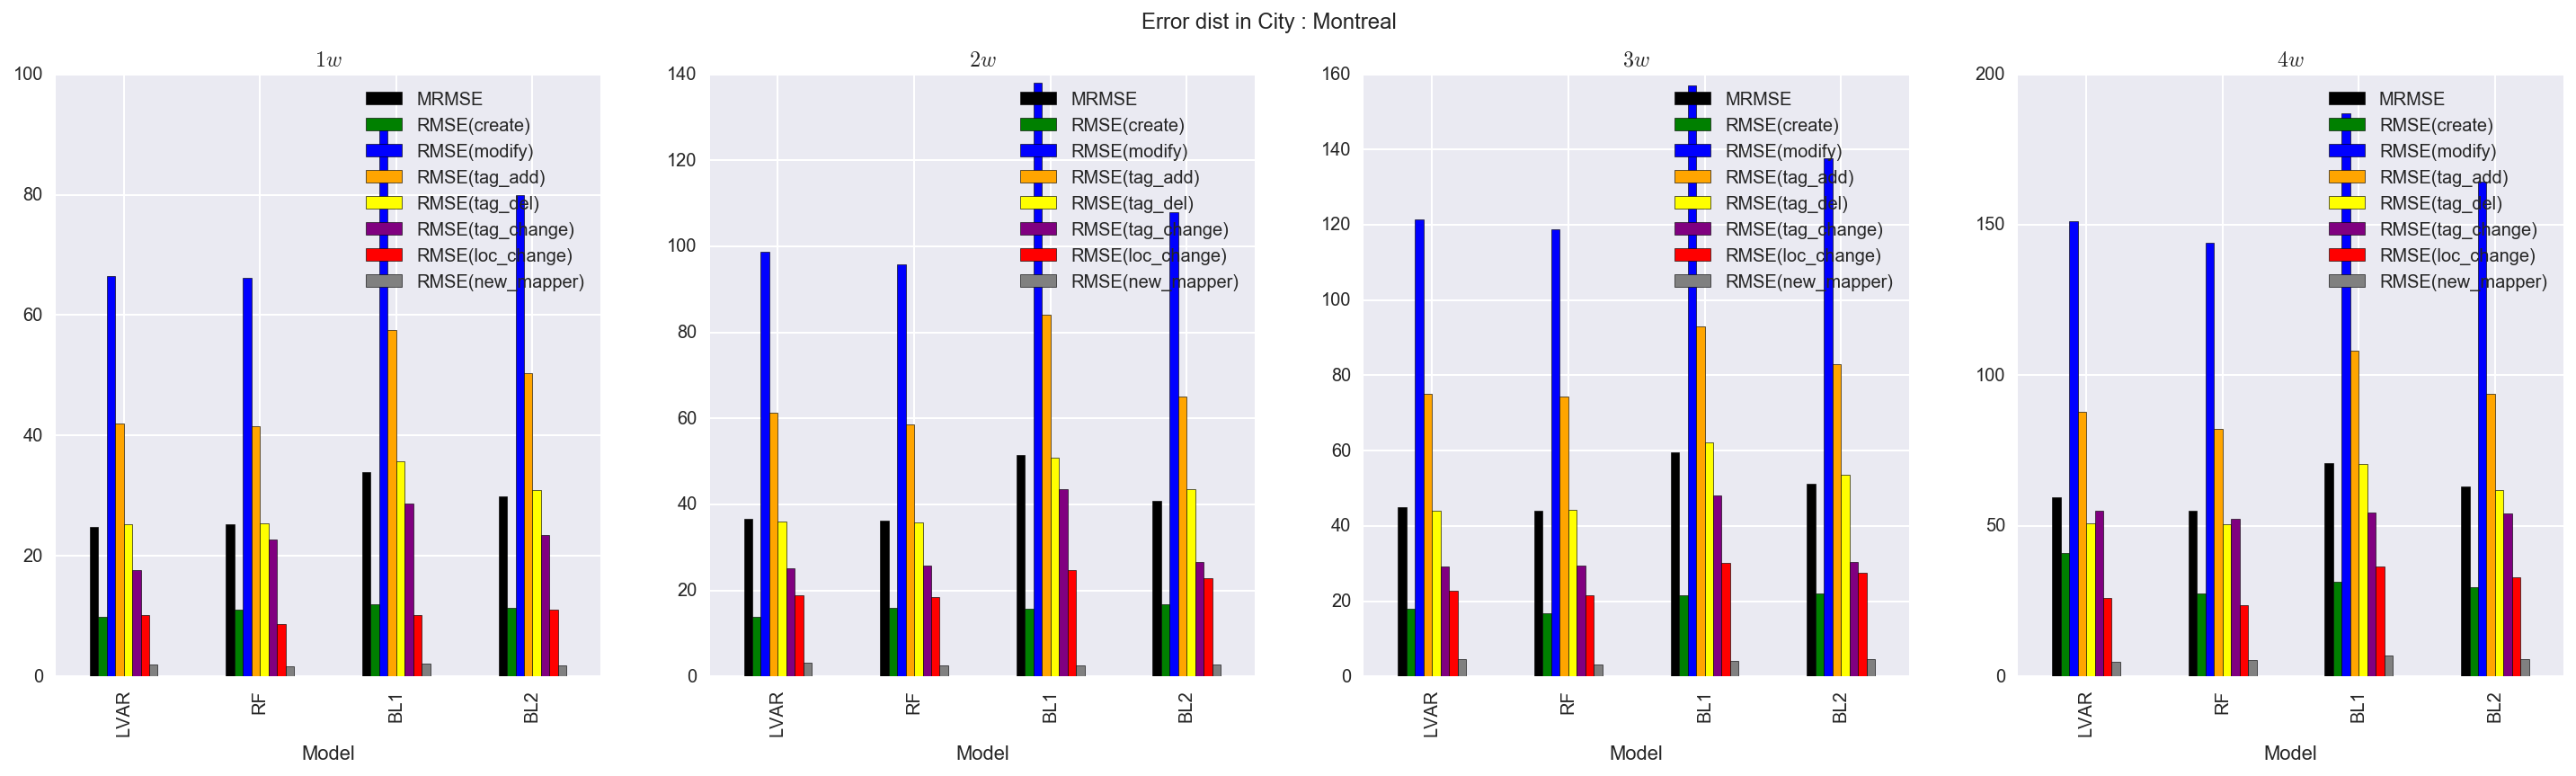

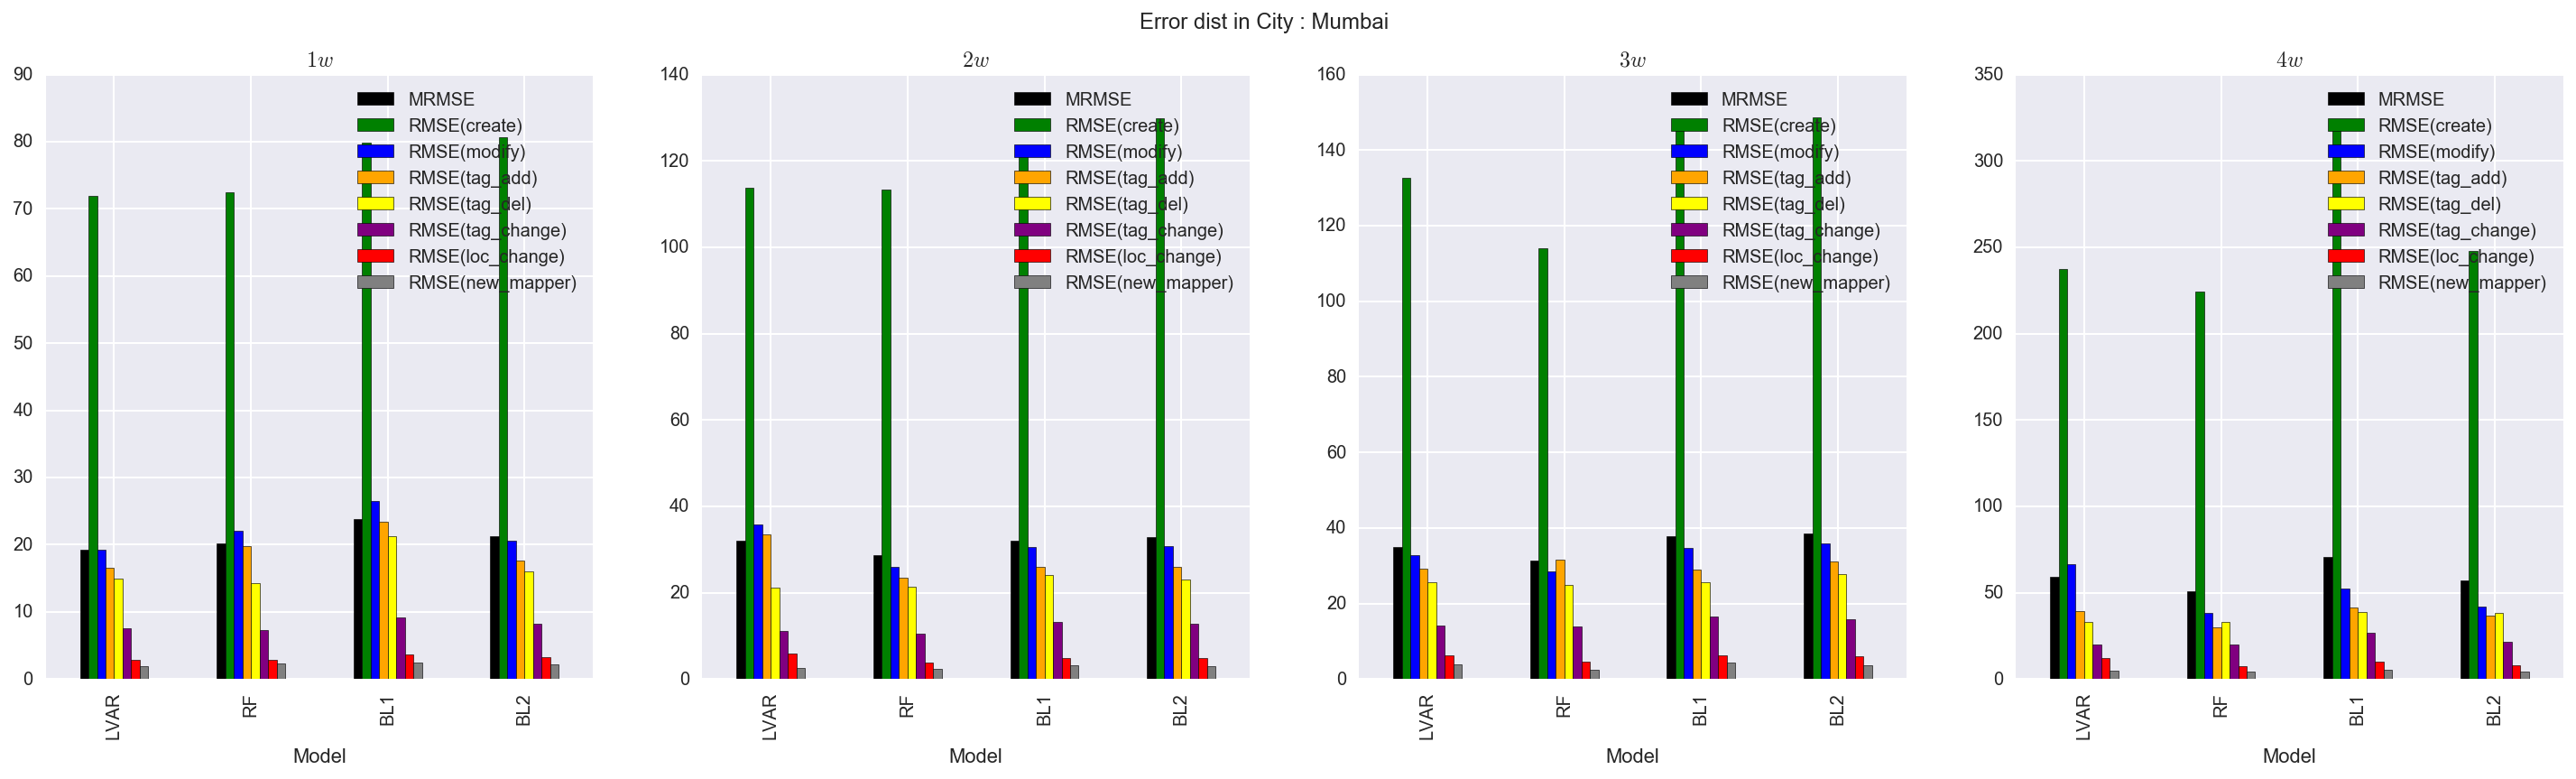

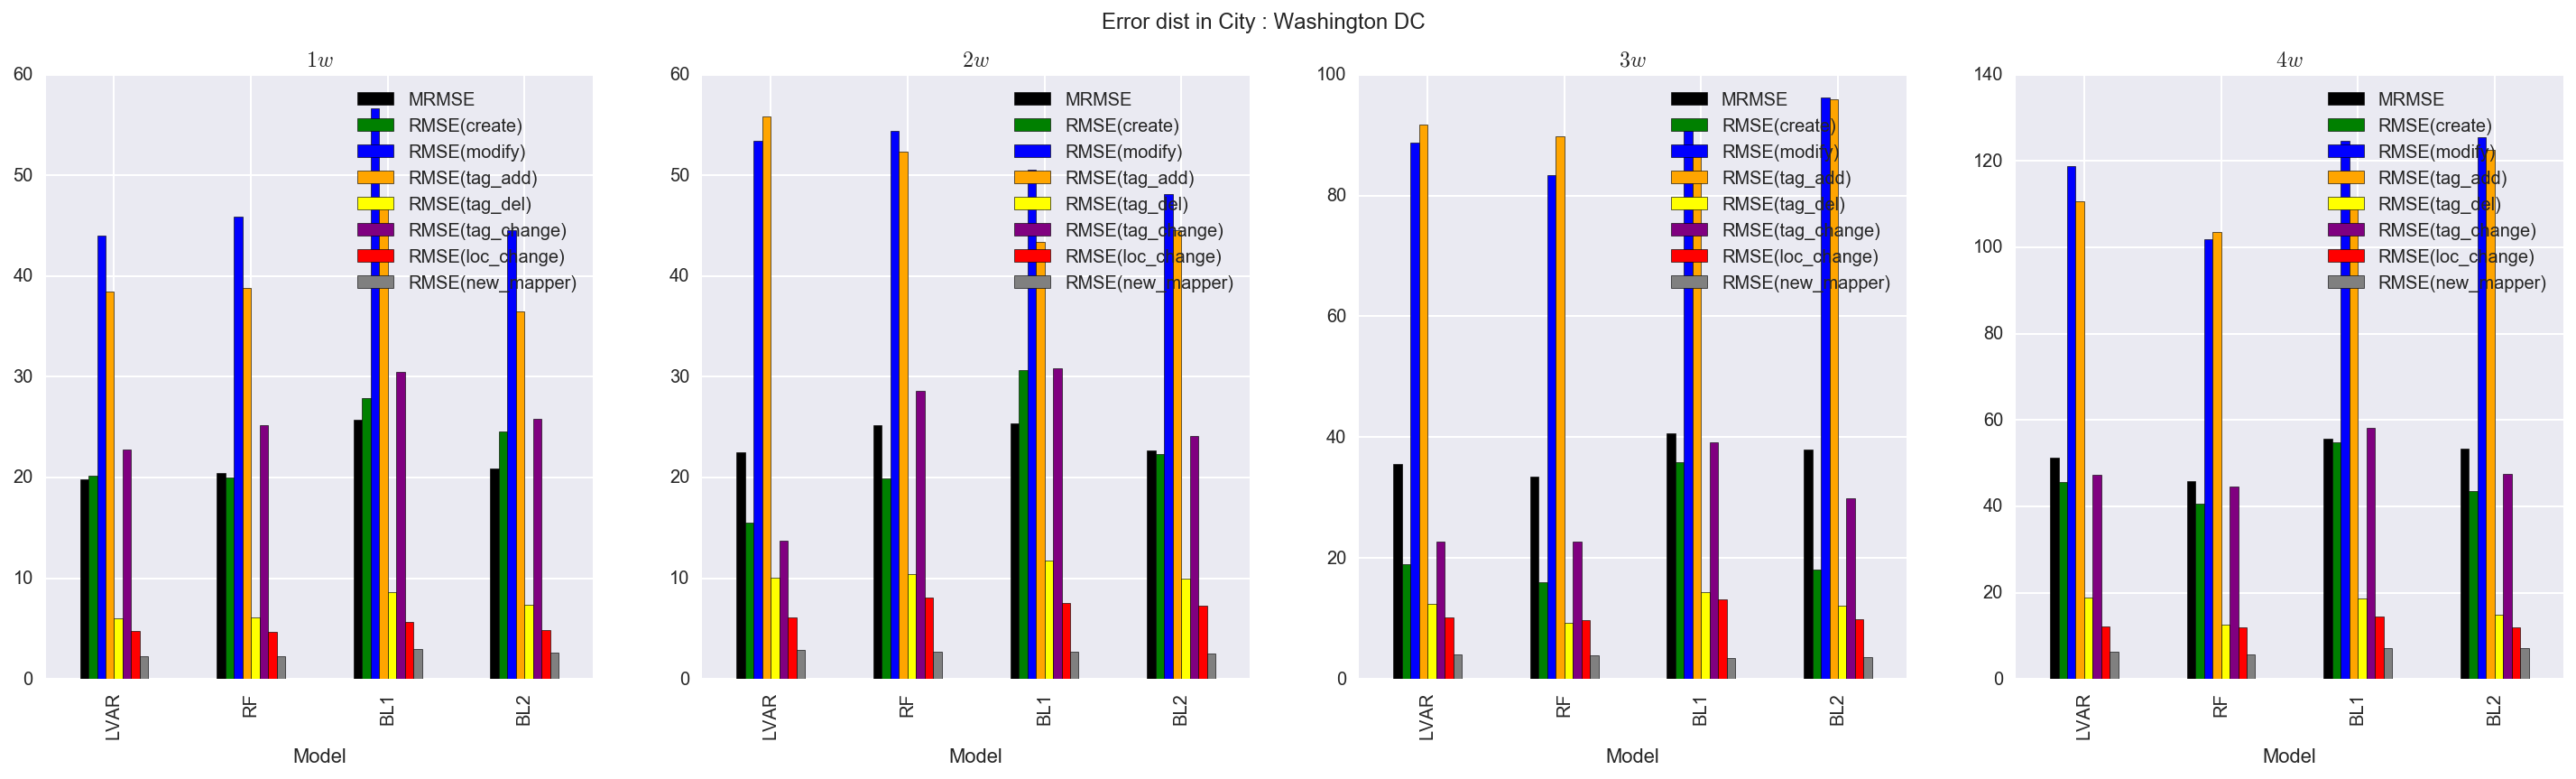

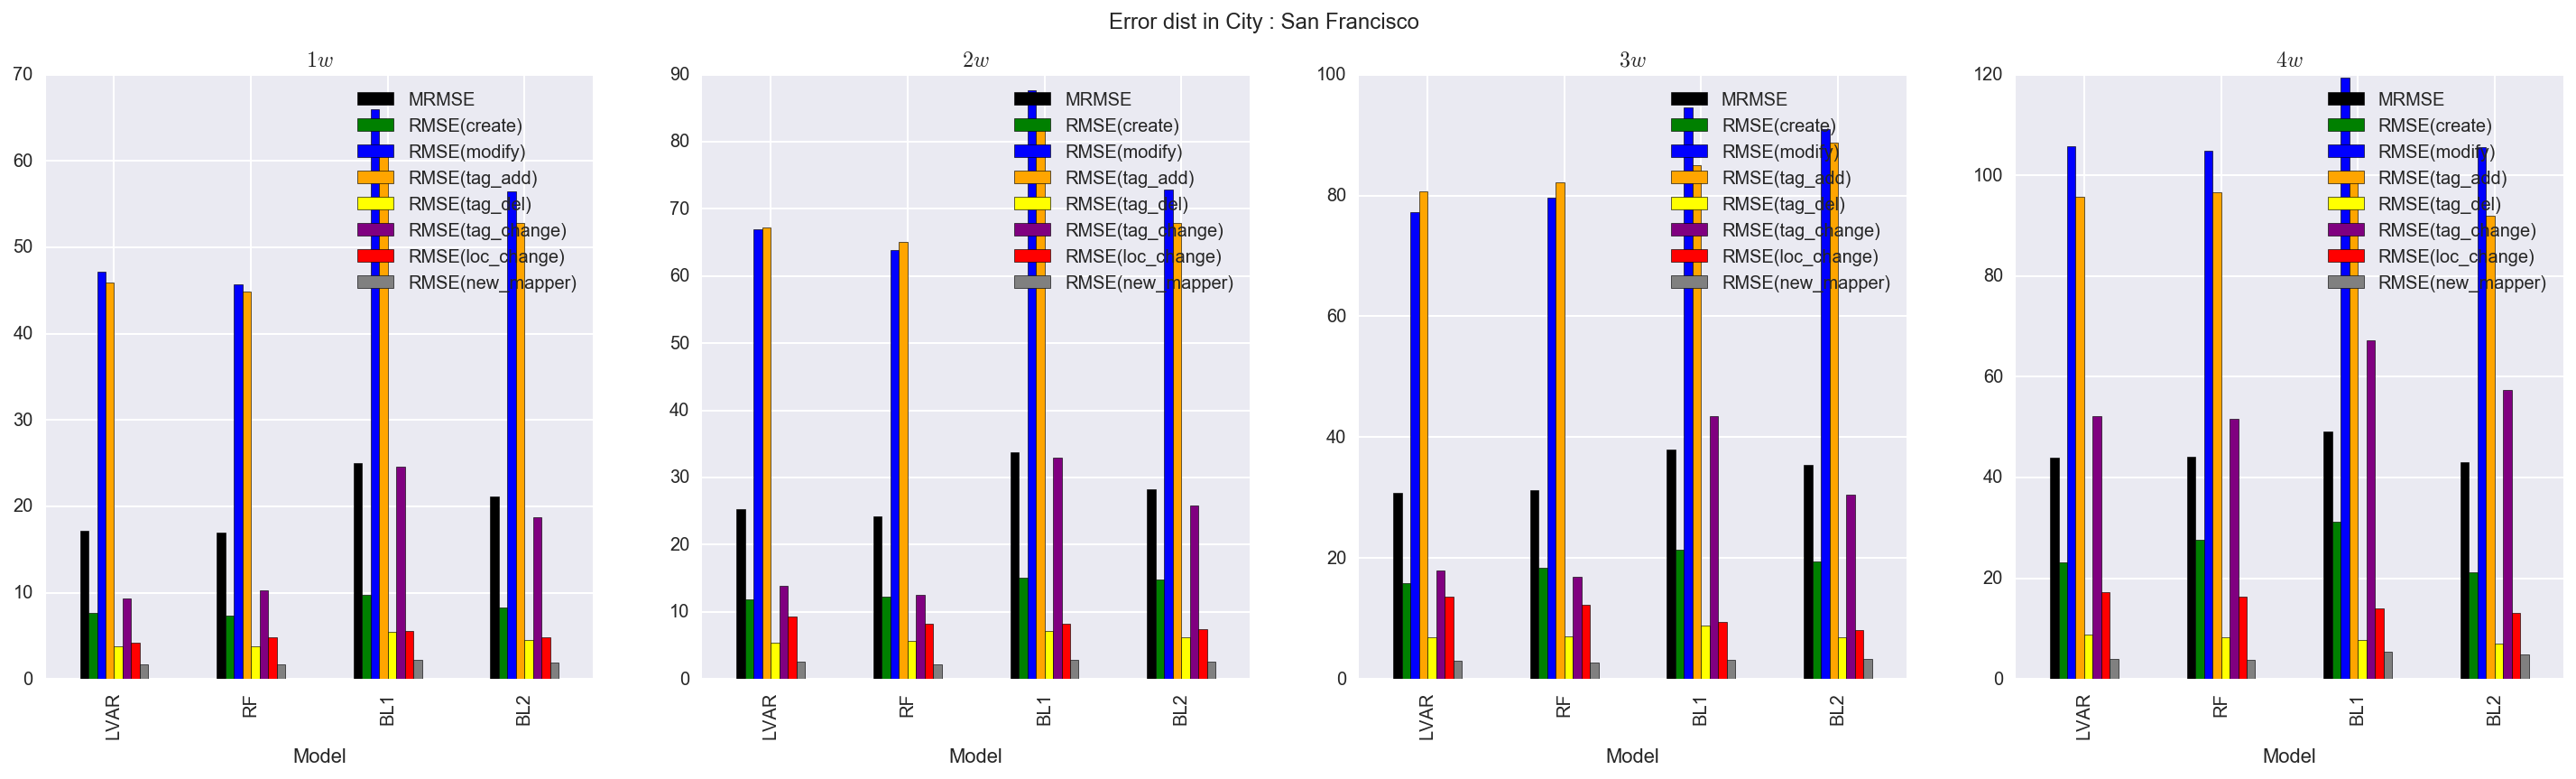

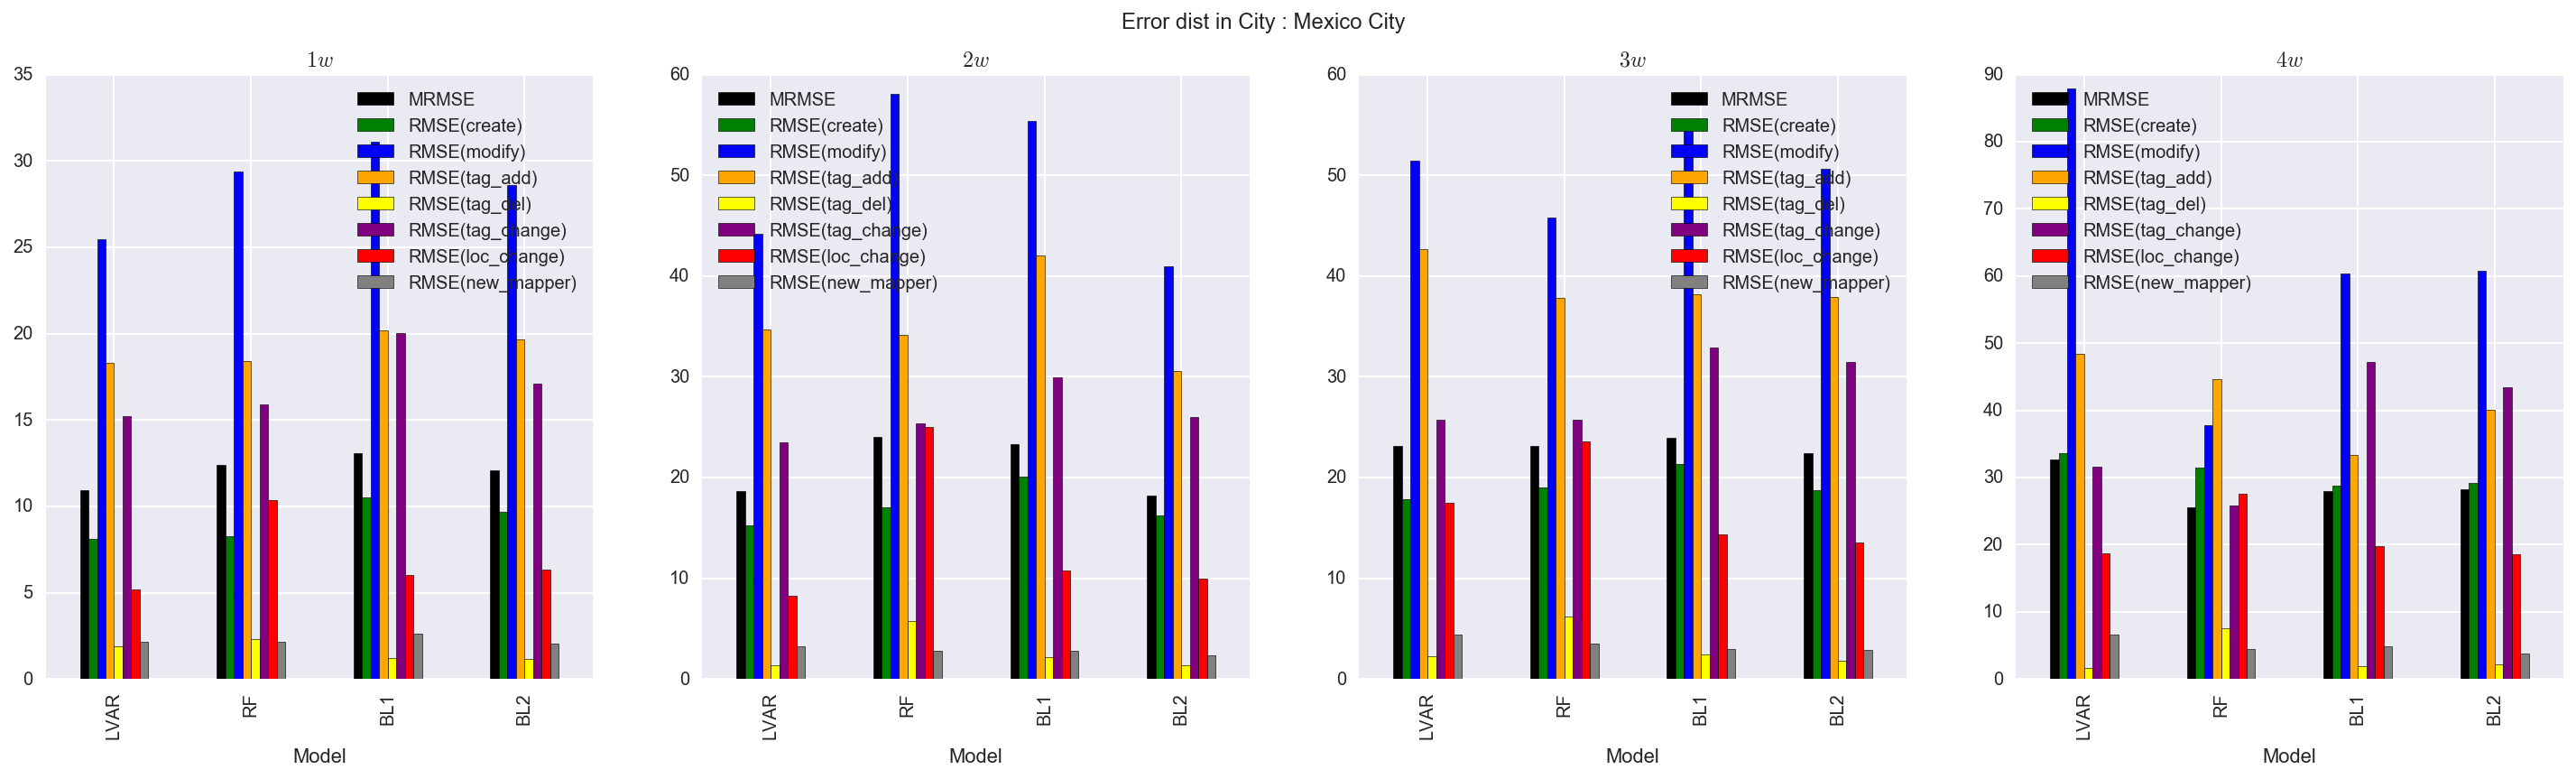

In [27]:
## For each city, show performance of the 3 models
metrics = ['MRMSE', 'RMSE(create)', 'RMSE(modify)',
           'RMSE(tag_add)',
           'RMSE(tag_del)', 'RMSE(tag_change)', 
           'RMSE(loc_change)', 'RMSE(new_mapper)']
for city in cities:
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25,6))
    model_results_w[city][metrics].plot(color=["black","green", "blue", "orange","yellow","purple", "red", "grey"], kind="bar",  grid=True, ax=axes[0]);axes[0].set_title("$1w$")
    model_results_2w[city][metrics].plot(color=["black","green", "blue", "orange","yellow","purple", "red", "grey"], kind="bar",  grid=True, ax=axes[1]);axes[1].set_title("$2w$")
    model_results_3w[city][metrics].plot(color=["black","green", "blue", "orange","yellow","purple", "red", "grey"], kind="bar",  grid=True, ax=axes[2]);axes[2].set_title("$3w$")
    model_results_m[city][metrics].plot(color=["black","green", "blue", "orange","yellow","purple", "red", "grey"], kind="bar", grid=True, ax=axes[3]);axes[3].set_title("$4w$")
    fig.suptitle('Error dist in City : % s' % city, fontsize=12)

In [28]:
VAR_results = pd.DataFrame([model_results_m[city].loc["LVAR"][metrics] for city in cities], index=cities)
RF_results = pd.DataFrame([model_results_m[city].loc["RF"][metrics] for city in cities], index=cities)
BL1_results = pd.DataFrame([model_results_m[city].loc["BL1"][metrics] for city in cities], index=cities)
BL2_results = pd.DataFrame([model_results_m[city].loc["BL2"][metrics] for city in cities], index=cities)

VAR_results.columns = ["MRMSE", "create", "modify", "tag_add", "tag_del", "tag_change", "loc_change", "new_mapper" ]
RF_results.columns = ["MRMSE", "create", "modify", "tag_add", "tag_del", "tag_change", "loc_change", "new_mapper" ]
BL1_results.columns = ["MRMSE", "create", "modify", "tag_add", "tag_del", "tag_change", "loc_change", "new_mapper" ]
BL2_results.columns = ["MRMSE", "create", "modify", "tag_add", "tag_del", "tag_change", "loc_change", "new_mapper" ]

In [29]:
plt.style.use("ggplot")

Text(0.5, 0.98, 'Error dist of the vector variables')

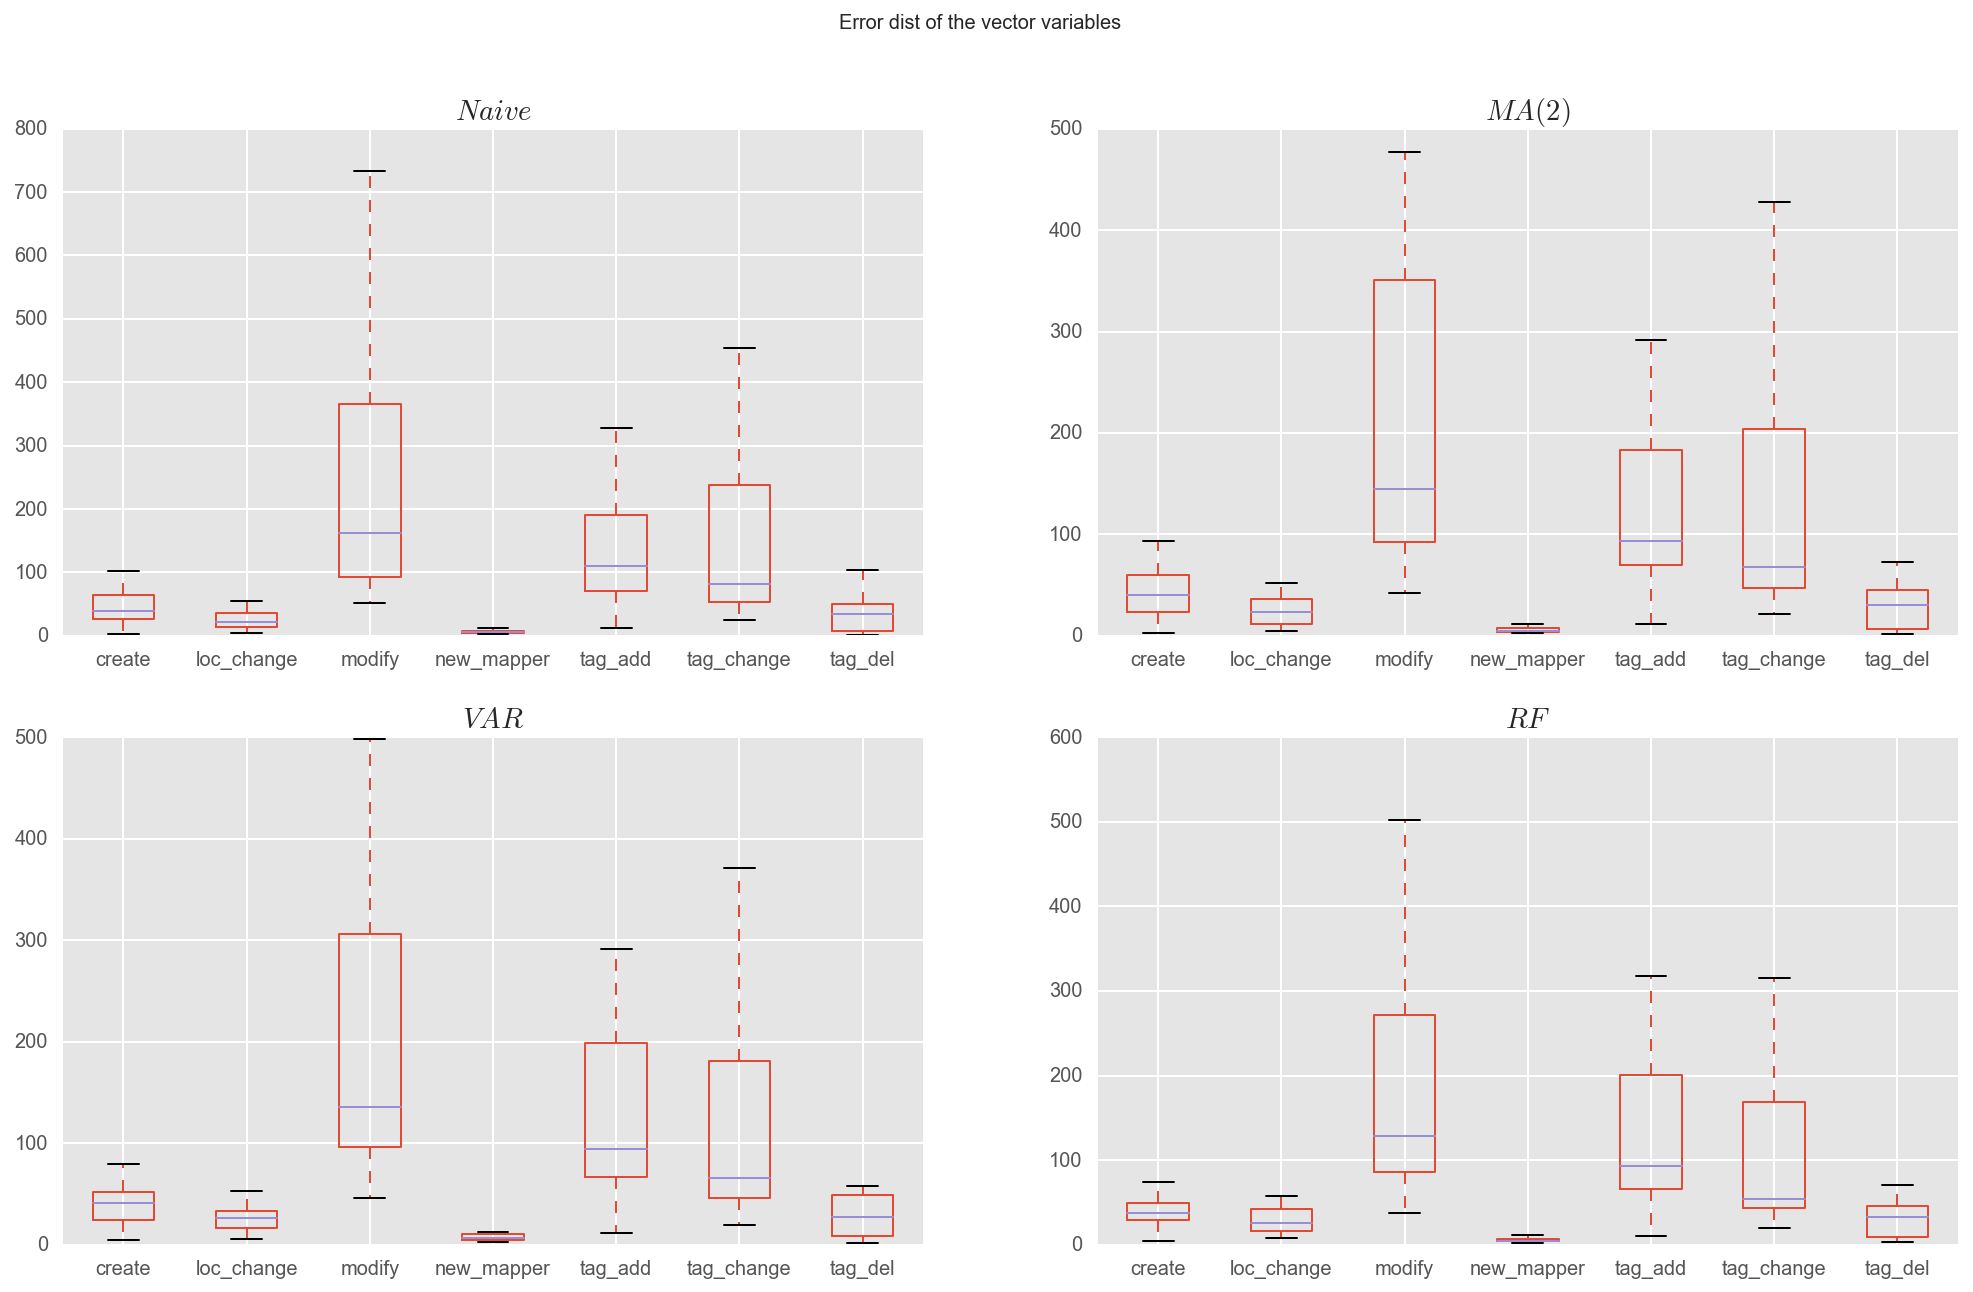

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,10))
BL1_results[BL1_results.columns.difference(["MRMSE"])].boxplot(grid=True, showfliers=False, ax=axes[0,0]);axes[0,0].set_title("$Naive$")
BL2_results[BL2_results.columns.difference(["MRMSE"])].boxplot(grid=True, showfliers=False, ax=axes[0,1]);axes[0,1].set_title("$MA(2)$")
VAR_results[VAR_results.columns.difference(["MRMSE"])].boxplot(grid=True, showfliers=False, ax=axes[1,0]);axes[1,0].set_title("$VAR$")
RF_results[RF_results.columns.difference(["MRMSE"])].boxplot(grid=True, showfliers=False, ax=axes[1,1]);axes[1,1].set_title("$RF$")
fig.suptitle("Error dist of the vector variables")